<a href="https://colab.research.google.com/github/tamotamo17/CZII/blob/main/exp061_4_2_5D_r05_ema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Feb  9 21:32:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Training base line for [CZII - CryoET Object Identification](https://www.kaggle.com/competitions/czii-cryo-et-object-identification)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
!cp /content/drive/MyDrive/ColabNotebooks/CZII/data/czii-dataset-0-5.zip /content
!unzip -q czii-dataset-0-5.zip -d /content
!rm czii-dataset-0-5.zip

!cp /content/drive/MyDrive/ColabNotebooks/CZII/data/czii-cryo-et-object-identification.zip /content
!unzip -q czii-cryo-et-object-identification.zip -d /content
!rm czii-cryo-et-object-identification.zip

CPU times: user 1.32 s, sys: 207 ms, total: 1.52 s
Wall time: 5min 3s


In [ ]:
!pip -q install timm
!pip install -q segmentation_models_pytorch
!pip install natsort cupy-cuda12x==13.3.0
!pip install connected-components-3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
DEBUG = False

In [ ]:
import os
import sys
import copy
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import h5py
from natsort import natsorted
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations as A
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
from timm.utils import ModelEmaV2



%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# Config

In [ ]:
class CFG:
    seed = 42
    kernel_type = 'exp060_4_2.5D_r05_ema'
    load_kernel = None
    load_last = True
    targets2idx = {'apo-ferritin': 1,
                   'beta-amylase': 2,
                   'beta-galactosidase': 3,
                   'ribosome': 4,
                   'thyroglobulin': 5,
                   'virus-like-particle': 6
                   }
    idx2targets = {1: 'apo-ferritin',
                   2: 'beta-amylase',
                   3: 'beta-galactosidase',
                   4: 'ribosome',
                   5: 'thyroglobulin',
                   6: 'virus-like-particle'
                   }
    colors = [[0, 117, 220],
              [153, 63, 0],
              [76, 0, 92],
              [ 0, 92, 49],
              [43, 206, 72],
              [255, 204, 153],
              ]
    samples = ['TS_5_4', 'TS_86_3', 'TS_73_6', 'TS_6_6',
               'TS_69_2', 'TS_99_9', 'TS_6_4'
               ]
    n_folds = 4
    backbone = "tu-tf_efficientnet_b0.ns_jft_in1k"#'tf_efficientnetv2_s_in21ft1k' #"tf_efficientnet_b0.ns_jft_in1k" #

    image_size = 640
    indices_ch = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
    in_chans = len(indices_ch)
    offset = 1

    init_lr = 1e-3#1e-3
    eta_min = 1e-8
    batch_size = 16
    drop_rate = 0.
    drop_rate_last = 0.1
    drop_path_rate = 0.
    p_mixup = 1.0#0.75
    p_rand_order_v1 = 0#0.2
    mid_range = 0
    p_drop_plane = 0.0

    data_dir = '/content/hdf5'
    use_amp = True
    num_workers = 4
    num_targets = len(targets2idx)

    n_epochs = 30
    n_epochs_mixup = n_epochs - 5
    loss_weights = [0.2, 0.4, 0.4]
    save_root = '/content/drive/MyDrive/ColabNotebooks/CZII/results'
    save_dir = os.path.join(save_root, kernel_type)

    log_dir = os.path.join('logs', save_dir)
    model_dir = os.path.join(save_dir, 'models')
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

In [ ]:

def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

set_random_seed(CFG.seed)

In [ ]:
transforms_train = A.Compose([
    #A.CenterCrop(180, 180, p=1.0),
    A.Resize(CFG.image_size, CFG.image_size),
    #A.RandomBrightness(limit=0.1, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.7),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, border_mode=0, p=0.7),

    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
        A.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.2),
    # A.OneOf([
    #     A.OpticalDistortion(distort_limit=1.0),
    #     A.GridDistortion(num_steps=5, distort_limit=1.),
    #     A.ElasticTransform(alpha=3),
    # ], p=0.5),

    #A.Cutout(max_h_size=int(CFG.image_size / 8), max_w_size=int(CFG.image_size /8), num_holes=3, p=0.5),
    #A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)), hole_width_range=(int(CFG.image_size / 16), int(CFG.image_size / 8)))
])

transforms_valid = A.Compose([
    #A.CenterCrop(180, 180, p=1.0),
    A.Resize(CFG.image_size, CFG.image_size),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-5-f5af22a3eb8b>:15: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(3.0, 9.0)),


# DataFrame

In [ ]:
file_paths = glob('/content/hdf5/*')
data_dicts = {}
df = []
for file_path in file_paths:
    print(file_path)
    base = file_path.split('/')[-1].split('.')[0]
    data = {}
    with h5py.File(file_path, 'r') as f:
        data['image'] = f['image'][:]
        data['label'] = f['label'][:]
    data_dicts[base] = data
    # スライス分のインデックス情報を取得
    num_slices = data['image'].shape[0]

    # データフレーム用のリストに情報を追加
    df_ = []
    for i in range(num_slices):
        df_.append({'sample_name': base, 'slice_index': i})
    df_ = pd.DataFrame(df_)
    df.append(df_)
df = pd.concat(df).reset_index(drop=True)

/content/hdf5/TS_99_9.h5
/content/hdf5/TS_5_4.h5
/content/hdf5/TS_69_2.h5
/content/hdf5/TS_6_6.h5
/content/hdf5/TS_73_6.h5
/content/hdf5/TS_86_3.h5
/content/hdf5/TS_6_4.h5


In [ ]:
df

,sample_name,slice_index
0,TS_99_9,0
1,TS_99_9,1
2,TS_99_9,2
3,TS_99_9,3
4,TS_99_9,4
...,...,...
1283,TS_6_4,179
1284,TS_6_4,180
1285,TS_6_4,181
1286,TS_6_4,182


In [ ]:
for key, data in data_dicts.items():
    img = data['image']
    lbl = data['label']
    print(f'{key} image shape: {img.shape}, label shape:{lbl.shape}')
    for i in range(1,7,1):
        print(f'{CFG.idx2targets[i]}: {np.sum(lbl==i)}')
    print('\n')

TS_99_9 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 4094
beta-amylase: 3022
beta-galactosidase: 8109
ribosome: 114886
thyroglobulin: 56400
virus-like-particle: 16740


TS_5_4 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 5201
beta-amylase: 1269
beta-galactosidase: 4617
ribosome: 54794
thyroglobulin: 34548
virus-like-particle: 14177


TS_69_2 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 3959
beta-amylase: 1730
beta-galactosidase: 6085
ribosome: 65337
thyroglobulin: 39124
virus-like-particle: 11598


TS_6_6 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 4638
beta-amylase: 2014
beta-galactosidase: 4205
ribosome: 40608
thyroglobulin: 40255
virus-like-particle: 24494


TS_73_6 image shape: (184, 630, 630), label shape:(184, 630, 630)
apo-ferritin: 10738
beta-amylase: 1727
beta-galactosidase: 5072
ribosome: 81175
thyroglobulin: 32231
virus-like-particle: 28342


TS_86_3 image shape: (184

In [ ]:
def color_labeling(lbl):
    z, h, w = lbl.shape
    new_lbl = np.zeros([z,h,w,3], dtype=np.uint8)
    for i in range(1, CFG.num_targets, 1):
        new_lbl[lbl==i] = CFG.colors[i-1]
    return new_lbl

def convert_to_rgb(img):
    img = img[...,np.newaxis]
    img = np.concatenate([img, img, img], axis=3)
    return img

def convert_to_8bit(img, p_min=0, p_max=100):
    lower, upper = np.percentile(img, (p_min, p_max))
    img = np.clip(img, lower, upper)
    img = (img - lower) / (upper - lower)
    img = (img * 255).astype(np.uint8)
    return img

def create_animation(ims):
    rc('animation', html='jshtml')
    fig = plt.figure(figsize=(6, 3))
    plt.axis('off')
    im = plt.imshow(ims[0], cmap="gray")
    text = plt.text(0.05, 0.05, f'index {1}', transform=fig.transFigure, fontsize=16, color='darkblue')
    def animate_func(i):
        im.set_array(ims[i])
        text.set_text(f'index {i+1}')
        return [im]
    plt.close()
    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000//10)

In [ ]:
# sample_id = 'TS_69_2'
# idx_start = 30
# nslice = 5
# offset = 5
# img = convert_to_rgb(convert_to_8bit(data_dicts[sample_id]['image'], 3, 99))
# lbl = color_labeling(data_dicts[sample_id]['label'])
# concat = np.concatenate([img, lbl], axis=2)
# # plt.figure(figsize=(12,4))
# # for i in range(nslice):
# #     plt.subplot(2, nslice, i+1)
# #     plt.imshow(img[i*offset+idx_start], cmap='gray')
# #     plt.subplot(2, nslice, i+1+nslice)
# #     plt.imshow(lbl[i*offset+idx_start])

# create_animation(concat)

# Dataset

In [ ]:
class CZIIDataset(Dataset):
    def __init__(self,
                 df,
                 data_dicts,
                 indices_ch,
                 mode='valid',
                 transform=None
                 ):

        self.df = df
        self.data_dicts = data_dicts
        self.indices_ch = indices_ch
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sample_name = row['sample_name']
        df_sample = self.df[self.df['sample_name'] == sample_name]
        n_slice = len(df_sample)
        slice_idx = row['slice_index']
        slice_indices = [np.clip(i+slice_idx, 0, n_slice-1) for i in self.indices_ch]
        img = self.data_dicts[sample_name]['image'][slice_indices].transpose(1,2,0)
        lbl = self.data_dicts[sample_name]['label'][slice_idx]
        img = convert_to_8bit(img, 1, 99)
        if self.transform is not None:
            aug = self.transform(image=img, mask=lbl)
            img = aug['image']
            lbl = aug['mask']
        img = img.astype(np.float32)/255.
        img = torch.tensor(img.transpose(2,0,1))
        lbl = torch.tensor(lbl, dtype=torch.long)
        return {'image': img,
                'label': lbl
                }

In [ ]:
data_dicts.keys()

dict_keys(['TS_99_9', 'TS_5_4', 'TS_69_2', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_6_4'])

In [ ]:
df['fold'] = -1
for fold, sample_name in enumerate(CFG.samples):
    df.loc[df['sample_name']==sample_name, 'fold'] = fold
df

,sample_name,slice_index,fold
0,TS_99_9,0,5
1,TS_99_9,1,5
2,TS_99_9,2,5
3,TS_99_9,3,5
4,TS_99_9,4,5
...,...,...,...
1283,TS_6_4,179,6
1284,TS_6_4,180,6
1285,TS_6_4,181,6
1286,TS_6_4,182,6


In [ ]:
rcParams['figure.figsize'] = 20,8
df_show = df
dataset_show = CZIIDataset(df_show,
                           data_dicts,
                           CFG.indices_ch,
                           'train',
                           transform=transforms_train
                           )
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)

torch.Size([16, 11, 640, 640]) torch.Size([16, 640, 640])


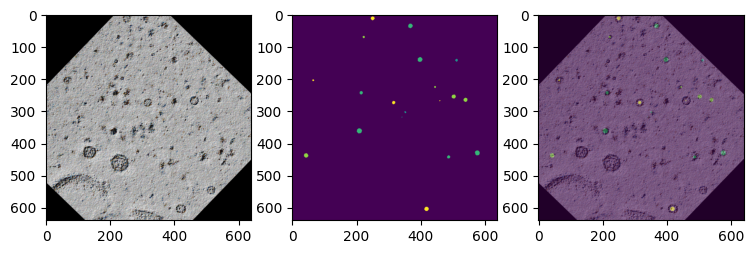

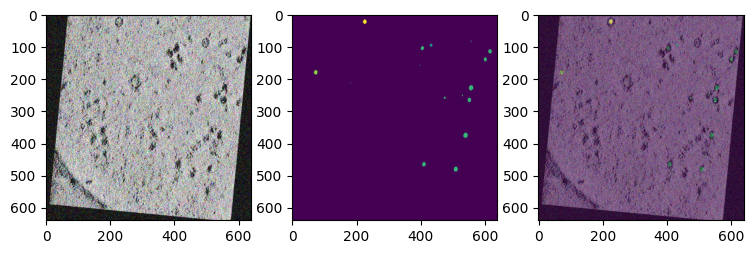

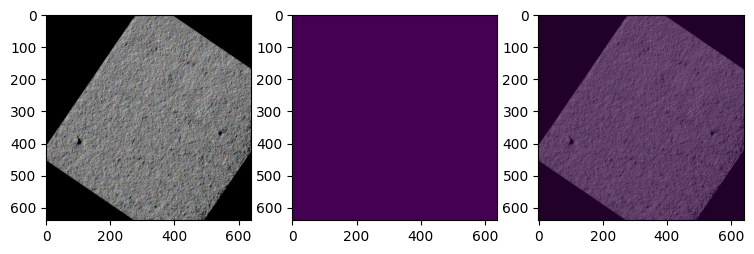

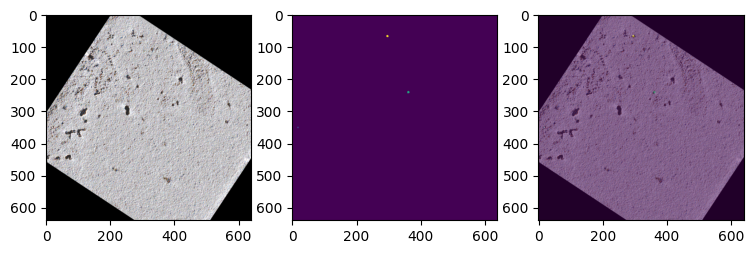

In [ ]:
for data in loader_show:
    imgs = data['image']
    label = data['label']
    for p in range(4):
        plt.figure(figsize=(9,3))
        plt.subplot(1,3,1)
        plt.imshow(imgs[p].permute(1, 2, 0)[...,1:4])
        plt.subplot(1,3,2)
        plt.imshow(label[p])
        plt.subplot(1,3,3)
        plt.imshow(imgs[p].permute(1, 2, 0)[...,1:4])
        plt.imshow(label[p], alpha=0.5)
    break
print(imgs.shape, label.shape)

In [ ]:
imgs.max(), imgs.min()

(tensor(1.), tensor(0.))

In [ ]:
imgs[p].shape, label.dtype

(torch.Size([11, 640, 640]), torch.int64)

In [ ]:
torch.unique(label)

tensor([0, 1, 2, 3, 4, 5, 6])

# Model

In [ ]:
m = smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=7,        # model output channels (number of classes in your dataset)
            activation=None,
            )
out = m(imgs)
out.shape

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


torch.Size([16, 7, 640, 640])

# Loss & Metric

In [ ]:
# criterion_multi(out.to('cpu'), label.to('cpu'),
#                     weights = torch.tensor([1.0, 2.0, 4.0]).to('cpu')
#                     )

In [ ]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
CELoss      = nn.CrossEntropyLoss()#smp.losses.SoftCrossEntropyLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multiclass', classes=[0,1,3,4,5,6], alpha=0.02, beta=0.98, log_loss=False)
FocalLoss = smp.losses.FocalLoss(mode='multilabel')

def criterion_seg(y_pred, y_true):
    # bs, n, c, h, w = y_true.shape[:2]
    # y_pred = y_pred.view(bs*n, c, h, w)
    # y_true = y_true.view(bs*n, c, h, w)
    bce = CELoss(y_pred, y_true) * 0.
    tvs = TverskyLoss(y_pred, y_true) * 1.
    return bce + tvs, bce, tvs

# Train & Valid func

In [ ]:
def fbeta_score_multiclass(y_true, y_pred, beta=1.0, num_classes=None, weights=[0,1,0,2,1,2,1]):
    if num_classes is None:
        num_classes = max(y_true.max(), y_pred.max()) + 1

    fbeta_scores = []
    class_names = ['background', 'apo-ferritin', 'beta-amylase', 'beta-galactosidase',
                   'ribosome', 'thyroglobulin', 'virus-like-particle',
                   ]
    for cls in range(num_classes):
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        if precision + recall == 0:
            fbeta = 0.0
        else:
            beta_sq = beta ** 2
            fbeta = (1 + beta_sq) * (precision * recall) / (beta_sq * precision + recall)
        print(f'{class_names[cls]}: {fbeta}')
        fbeta_scores.append(fbeta*weights[cls])

    return np.mean(fbeta_scores)

In [ ]:
def mixup(input, mask, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_mask = mask[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, mask, shuffled_mask, lam


def train_func(model, ema, loader_train, optimizer, epoch, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for data in bar:
        optimizer.zero_grad()
        images = data['image']
        masks = data['label']
        images = images.to(device)
        masks = masks.to(device)

        do_mixup = False
        if (random.random() < CFG.p_mixup)&(CFG.n_epochs_mixup>epoch):
            do_mixup = True
            images, masks, masks_mix, lam = mixup(images, masks)

        with amp.autocast():
            logits = model(images)
            loss, _, _ = criterion_seg(logits, masks)
            if do_mixup:
                loss11, _, _ = criterion_seg(logits, masks_mix)
                loss = loss * lam  + loss11 * (1 - lam)
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ema.update(model)
        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(ema, loader_valid):
    ema.module.eval()
    valid_loss, valid_loss_bce, valid_loss_tvs = [], [], []
    gts, outputs = [], []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for data in bar:
            images = data['image']
            masks = data['label']
            images = images.to(device)
            masks = masks.to(device)

            logits = ema.module(images)
            gts.append(masks.cpu().detach().numpy())
            outputs.append(logits.cpu().detach().numpy())
            loss, loss_bce, loss_tvs = criterion_seg(logits, masks)
            valid_loss.append(loss.item())
            valid_loss_bce.append(loss_bce.item())
            valid_loss_tvs.append(loss_tvs.item())

            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
    gts = np.concatenate(gts)
    outputs = np.concatenate(outputs)
    outputs = outputs.argmax(1)
    score = fbeta_score_multiclass(gts, outputs, beta=4.0, num_classes=7)
    return np.mean(valid_loss), np.mean(valid_loss_bce), np.mean(valid_loss_tvs), score

def inf_func(model, loader_valid, size):
    model.eval()
    valid_loss, valid_loss_bce, valid_loss_tvs = [], [], []
    gts, outputs = [], []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for data in bar:
            images = data['image']
            masks = data['label']
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            loss, loss_bce, loss_tvs = criterion_seg(logits, masks)
            gts.append(masks.cpu())
            outputs.append(logits.cpu())

            valid_loss.append(loss.item())
            valid_loss_bce.append(loss_bce.item())
            valid_loss_tvs.append(loss_tvs.item())

            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
    gts = torch.concat(gts)
    outputs = torch.concat(outputs)
    print(gts.shape, outputs.shape)
    outputs = outputs.permute(1, 0, 2, 3)  # [channels, depth, height, width]
    channels, depth, height, width = outputs.shape
    # リサイズのために形状を変更
    #outputs = outputs.reshape(channels * depth, 1, height, width)  # [channels * depth, 1, height, width]
    outputs = F.interpolate(outputs.unsqueeze(0), size=size, mode='trilinear', align_corners=False).squeeze(0)  # [channels * depth, 1, new_height, new_width]
    #outputs = outputs.reshape(channels, depth, size, size)  # [channels, depth, new_height, new_width]

    # masksをリサイズ
    # [batch=depth, height, width] -> [depth, new_height, new_width]
    gts = F.interpolate(gts.unsqueeze(0).unsqueeze(0).float(), size=size, mode='nearest').squeeze(0).squeeze(0).long()  # [depth, new_height, new_width]

    return gts, outputs, np.mean(valid_loss), np.mean(valid_loss_bce), np.mean(valid_loss_tvs)

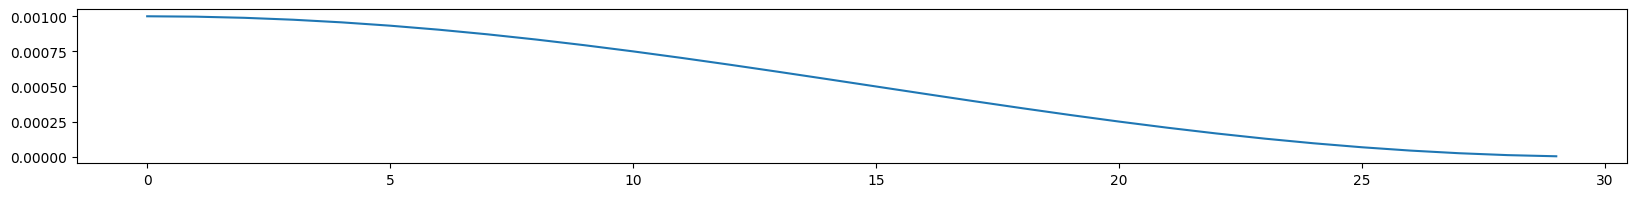

In [ ]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=1e-3)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, T_mult=1, eta_min=CFG.eta_min)

lrs = []
for epoch in range(1, CFG.n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

# Training

In [ ]:
def run(fold):

    log_file = os.path.join(CFG.log_dir, f'{CFG.kernel_type}.txt')
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')

    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = CZIIDataset(train_,
                                data_dicts,
                                CFG.indices_ch,
                                'train', transform=transforms_train
                               )
    dataset_valid = CZIIDataset(valid_,
                                data_dicts,
                                CFG.indices_ch,
                                'valid', transform=transforms_valid
                               )
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    model = smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                     in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                     classes=7,        # model output channels (number of classes in your dataset)
                     activation=None,
                     )
    model = model.to(device)
    model_ema = ModelEmaV2(model, decay=0.995)

    optimizer = optim.AdamW(model.parameters(), lr=CFG.init_lr)
    scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None

    metric_best = -np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, eta_min=CFG.eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, CFG.n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, model_ema, loader_train, optimizer, epoch, scaler)
        valid_loss, valid_loss_bce, valid_loss_tvs, valid_score = valid_func(model_ema, loader_valid)
        metric = valid_score

        content = (
            f"{time.ctime()} "
            f"Fold {fold}, "
            f"Epoch {epoch}, "
            f"lr: {optimizer.param_groups[0]['lr']:.7f}, "
            f"train loss: {train_loss:.5f}, \n"
            f"valid loss: {valid_loss:.5f}, "
            f"valid loss bce: {valid_loss_bce:.5f}, "
            f"valid loss tvs: {valid_loss_tvs:.5f}, "
            f"metric: {metric:.6f}, "
            f"valid f4: {valid_score:.4f}, "
        )

        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model_ema.module.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model_ema.module.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()
    return metric_best

def run_inference(fold, size):
    log_file = os.path.join(CFG.log_dir, f'{CFG.kernel_type}.txt')
    model_file = os.path.join(CFG.model_dir, f'{CFG.kernel_type}_fold{fold}_best.pth')

    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_valid = CZIIDataset(valid_,
                                data_dicts,
                                CFG.indices_ch,
                                'valid', transform=transforms_valid
                               )
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
    model = smp.Unet(encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                    in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                    classes=7,        # model output channels (number of classes in your dataset)
                    activation=None,
                    )
    model.load_state_dict(torch.load(model_file))
    model = model.eval().to(device)
    gts, outputs, _, _, _ = inf_func(model, loader_valid, size)
    return gts, outputs



In [ ]:
RUN_TRAIN = True
if RUN_TRAIN:
    folds = [1, 2]
    best_scores = []
    for i in folds:
        best_score = run(i)
        best_scores.append(best_score)
    print(best_scores)
    print(np.mean(best_scores))

<ipython-input-25-35417232907d>:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 184
Mon Feb 10 06:37:10 2025 Epoch: 1


  0%|          | 0/69 [00:00<?, ?it/s]<ipython-input-23-08dc36a7f15a>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
smth:0.5993: 100%|██████████| 12/12 [00:20<00:00,  1.73s/it]


background: 0.7114649850997097
apo-ferritin: 0.0018852385999421886
beta-amylase: 0.0002952327508637186
beta-galactosidase: 0.0
ribosome: 0.006452240970744337
thyroglobulin: 0.059128019097156134
virus-like-particle: 0.016262881180476293
Mon Feb 10 06:39:06 2025 Fold 1, Epoch 1, lr: 0.0010000, train loss: 0.72102, 
valid loss: 0.59932, valid loss bce: 0.00000, valid loss tvs: 0.59932, metric: 0.020408, valid f4: 0.0204, 
metric_best (-inf --> 0.020408). Saving model ...
Mon Feb 10 06:39:07 2025 Epoch: 2


smth:0.5007: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9995329604934844
apo-ferritin: 0.00042403884528402285
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.06664143451014456
thyroglobulin: 0.07154441855930609
virus-like-particle: 0.015808323267530344
Mon Feb 10 06:40:37 2025 Fold 1, Epoch 2, lr: 0.0009973, train loss: 0.48493, 
valid loss: 0.50073, valid loss bce: 0.00000, valid loss tvs: 0.50073, metric: 0.032280, valid f4: 0.0323, 
metric_best (0.020408 --> 0.032280). Saving model ...
Mon Feb 10 06:40:38 2025 Epoch: 3


smth:0.4115: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9986006309101679
apo-ferritin: 0.0
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.5407830342577489
thyroglobulin: 0.16952780796095884
virus-like-particle: 0.6887854998702919
Mon Feb 10 06:42:08 2025 Fold 1, Epoch 3, lr: 0.0009891, train loss: 0.37573, 
valid loss: 0.41148, valid loss bce: 0.00000, valid loss tvs: 0.41148, metric: 0.224089, valid f4: 0.2241, 
metric_best (0.032280 --> 0.224089). Saving model ...
Mon Feb 10 06:42:08 2025 Epoch: 4


smth:0.3142: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9961218569463646
apo-ferritin: 0.0872011251758087
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.7413002062502441
thyroglobulin: 0.4019655815882231
virus-like-particle: 0.8999540421855043
Mon Feb 10 06:43:39 2025 Fold 1, Epoch 4, lr: 0.0009755, train loss: 0.34068, 
valid loss: 0.31422, valid loss bce: 0.00000, valid loss tvs: 0.31422, metric: 0.361770, valid f4: 0.3618, 
metric_best (0.224089 --> 0.361770). Saving model ...
Mon Feb 10 06:43:39 2025 Epoch: 5


smth:0.2400: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9937475445934818
apo-ferritin: 0.4847908745247148
beta-amylase: 0.0
beta-galactosidase: 0.010603518733600036
ribosome: 0.7746531610755774
thyroglobulin: 0.5399638765921826
virus-like-particle: 0.8975752590517205
Mon Feb 10 06:45:09 2025 Fold 1, Epoch 5, lr: 0.0009568, train loss: 0.33689, 
valid loss: 0.24005, valid loss bce: 0.00000, valid loss tvs: 0.24005, metric: 0.465451, valid f4: 0.4655, 
metric_best (0.361770 --> 0.465451). Saving model ...
Mon Feb 10 06:45:10 2025 Epoch: 6


smth:0.1939: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9919439349297037
apo-ferritin: 0.6778661606947385
beta-amylase: 0.0
beta-galactosidase: 0.14332377474745392
ribosome: 0.7792343495785565
thyroglobulin: 0.598819608204777
virus-like-particle: 0.8937525577265885
Mon Feb 10 06:46:40 2025 Fold 1, Epoch 6, lr: 0.0009330, train loss: 0.31056, 
valid loss: 0.19391, valid loss bce: 0.00000, valid loss tvs: 0.19391, metric: 0.547877, valid f4: 0.5479, 
metric_best (0.465451 --> 0.547877). Saving model ...
Mon Feb 10 06:46:41 2025 Epoch: 7


smth:0.1619: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9903573628077094
apo-ferritin: 0.7484776423043616
beta-amylase: 0.0
beta-galactosidase: 0.3116915062030513
ribosome: 0.776898751201896
thyroglobulin: 0.6122609325264905
virus-like-particle: 0.892930811284286
Mon Feb 10 06:48:11 2025 Fold 1, Epoch 7, lr: 0.0009045, train loss: 0.29564, 
valid loss: 0.16185, valid loss bce: 0.00000, valid loss tvs: 0.16185, metric: 0.609459, valid f4: 0.6095, 
metric_best (0.547877 --> 0.609459). Saving model ...
Mon Feb 10 06:48:12 2025 Epoch: 8


smth:0.1458: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9886322481919873
apo-ferritin: 0.7616028388224626
beta-amylase: 0.0
beta-galactosidase: 0.3876864099026021
ribosome: 0.7706173671443985
thyroglobulin: 0.6051300429825708
virus-like-particle: 0.8903454593974476
Mon Feb 10 06:49:42 2025 Fold 1, Epoch 8, lr: 0.0008716, train loss: 0.30083, 
valid loss: 0.14579, valid loss bce: 0.00000, valid loss tvs: 0.14579, metric: 0.629743, valid f4: 0.6297, 
metric_best (0.609459 --> 0.629743). Saving model ...
Mon Feb 10 06:49:42 2025 Epoch: 9


smth:0.1343: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.988317221169416
apo-ferritin: 0.7579212909850352
beta-amylase: 0.0
beta-galactosidase: 0.44882685977616854
ribosome: 0.7760832330217046
thyroglobulin: 0.6038759997315748
virus-like-particle: 0.8923950964574799
Mon Feb 10 06:51:13 2025 Fold 1, Epoch 9, lr: 0.0008346, train loss: 0.29537, 
valid loss: 0.13432, valid loss bce: 0.00000, valid loss tvs: 0.13432, metric: 0.647401, valid f4: 0.6474, 
metric_best (0.629743 --> 0.647401). Saving model ...
Mon Feb 10 06:51:13 2025 Epoch: 10


smth:0.1268: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9880900826155745
apo-ferritin: 0.7536317910587647
beta-amylase: 0.0
beta-galactosidase: 0.4969369137737518
ribosome: 0.7798297879336967
thyroglobulin: 0.6024692887499603
virus-like-particle: 0.8949012294515817
Mon Feb 10 06:52:43 2025 Fold 1, Epoch 10, lr: 0.0007939, train loss: 0.29454, 
valid loss: 0.12679, valid loss bce: 0.00000, valid loss tvs: 0.12679, metric: 0.661025, valid f4: 0.6610, 
metric_best (0.647401 --> 0.661025). Saving model ...
Mon Feb 10 06:52:44 2025 Epoch: 11


smth:0.1232: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


background: 0.9881689186311443
apo-ferritin: 0.7560304445987104
beta-amylase: 0.0
beta-galactosidase: 0.524597020378534
ribosome: 0.7834719510582524
thyroglobulin: 0.5985628404751419
virus-like-particle: 0.8986453774285061
Mon Feb 10 06:54:14 2025 Fold 1, Epoch 11, lr: 0.0007500, train loss: 0.28645, 
valid loss: 0.12320, valid loss bce: 0.00000, valid loss tvs: 0.12320, metric: 0.669210, valid f4: 0.6692, 
metric_best (0.661025 --> 0.669210). Saving model ...
Mon Feb 10 06:54:14 2025 Epoch: 12


smth:0.1211: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9884854811784296
apo-ferritin: 0.7538758123192687
beta-amylase: 0.0
beta-galactosidase: 0.5361271885225756
ribosome: 0.7865969744074645
thyroglobulin: 0.599908709676927
virus-like-particle: 0.9022323889931555
Mon Feb 10 06:55:44 2025 Fold 1, Epoch 12, lr: 0.0007034, train loss: 0.28211, 
valid loss: 0.12105, valid loss bce: 0.00000, valid loss tvs: 0.12105, metric: 0.673540, valid f4: 0.6735, 
metric_best (0.669210 --> 0.673540). Saving model ...
Mon Feb 10 06:55:45 2025 Epoch: 13


smth:0.1206: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9886493303824959
apo-ferritin: 0.7543672058585834
beta-amylase: 0.0
beta-galactosidase: 0.538474406155905
ribosome: 0.7889211963000807
thyroglobulin: 0.6032386312396156
virus-like-particle: 0.9029264562285224
Mon Feb 10 06:57:15 2025 Fold 1, Epoch 13, lr: 0.0006545, train loss: 0.27979, 
valid loss: 0.12055, valid loss bce: 0.00000, valid loss tvs: 0.12055, metric: 0.675663, valid f4: 0.6757, 
metric_best (0.673540 --> 0.675663). Saving model ...
Mon Feb 10 06:57:15 2025 Epoch: 14


smth:0.1194: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.988778872598101
apo-ferritin: 0.7590225775575701
beta-amylase: 0.0
beta-galactosidase: 0.5435381173636207
ribosome: 0.7912754457557287
thyroglobulin: 0.6047462970091358
virus-like-particle: 0.9067180253212713
Mon Feb 10 06:58:46 2025 Fold 1, Epoch 14, lr: 0.0006040, train loss: 0.27286, 
valid loss: 0.11940, valid loss bce: 0.00000, valid loss tvs: 0.11940, metric: 0.679084, valid f4: 0.6791, 
metric_best (0.675663 --> 0.679084). Saving model ...
Mon Feb 10 06:58:47 2025 Epoch: 15


smth:0.1187: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.989179631704523
apo-ferritin: 0.7598038602504285
beta-amylase: 0.0
beta-galactosidase: 0.5395516471594584
ribosome: 0.7967230533810907
thyroglobulin: 0.6058550922075532
virus-like-particle: 0.9111704911942995
Mon Feb 10 07:00:18 2025 Fold 1, Epoch 15, lr: 0.0005523, train loss: 0.26894, 
valid loss: 0.11871, valid loss bce: 0.00000, valid loss tvs: 0.11871, metric: 0.679787, valid f4: 0.6798, 
metric_best (0.679084 --> 0.679787). Saving model ...
Mon Feb 10 07:00:18 2025 Epoch: 16


smth:0.1187: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9896966838589524
apo-ferritin: 0.7643635674343663
beta-amylase: 0.0
beta-galactosidase: 0.5391071060053656
ribosome: 0.8006453316947776
thyroglobulin: 0.6086330691463432
virus-like-particle: 0.9156590362690341
Mon Feb 10 07:01:49 2025 Fold 1, Epoch 16, lr: 0.0005000, train loss: 0.25701, 
valid loss: 0.11868, valid loss bce: 0.00000, valid loss tvs: 0.11868, metric: 0.682307, valid f4: 0.6823, 
metric_best (0.679787 --> 0.682307). Saving model ...
Mon Feb 10 07:01:49 2025 Epoch: 17


smth:0.1186: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.990024159807415
apo-ferritin: 0.7672290897110164
beta-amylase: 0.0
beta-galactosidase: 0.5315784906110671
ribosome: 0.8028269396056025
thyroglobulin: 0.6102435851773851
virus-like-particle: 0.9191810666004329
Mon Feb 10 07:03:21 2025 Fold 1, Epoch 17, lr: 0.0004477, train loss: 0.26638, 
valid loss: 0.11858, valid loss bce: 0.00000, valid loss tvs: 0.11858, metric: 0.681840, valid f4: 0.6818, 
Mon Feb 10 07:03:21 2025 Epoch: 18


smth:0.2581:  33%|███▎      | 23/69 [00:27<00:44,  1.03it/s]

In [ ]:
RUN_TRAIN = True
if RUN_TRAIN:
    folds = [3, 4, 5, 6]
    best_scores = []
    for i in folds:
        best_score = run(i)
        best_scores.append(best_score)
    print(best_scores)
    print(np.mean(best_scores))

<ipython-input-29-c3b449c5a6c5>:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None


1104 184
Fri Dec 27 23:14:22 2024 Epoch: 1


  0%|          | 0/69 [00:00<?, ?it/s]<ipython-input-27-eddc6b8f1db7>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
smth:0.2278: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9943436203275285
apo-ferritin: 0.0
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.5947522721622144
thyroglobulin: 0.00010125014145240351
virus-like-particle: 0.0
Fri Dec 27 23:15:55 2024 Fold 3, Epoch 1, lr: 0.0040000, train loss: 0.45630, 
valid loss: 0.22777, valid loss bce: 0.01784, valid loss tvs: 0.20993, metric: 0.084994, valid f4: 0.0850, 
metric_best (-inf --> 0.084994). Saving model ...
Fri Dec 27 23:15:56 2024 Epoch: 2


smth:0.1982: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9908171373437503
apo-ferritin: 0.0
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.7480599927266894
thyroglobulin: 0.4260282193965422
virus-like-particle: 0.8398410525670623
Fri Dec 27 23:17:29 2024 Fold 3, Epoch 2, lr: 0.0039754, train loss: 0.33770, 
valid loss: 0.19822, valid loss bce: 0.01164, valid loss tvs: 0.18658, metric: 0.348565, valid f4: 0.3486, 
metric_best (0.084994 --> 0.348565). Saving model ...
Fri Dec 27 23:17:29 2024 Epoch: 3


smth:0.1955: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9892118567601057
apo-ferritin: 0.0
beta-amylase: 0.0
beta-galactosidase: 0.12968363615484982
ribosome: 0.7566579898754153
thyroglobulin: 0.38561016209247395
virus-like-particle: 0.5095959025436052
Fri Dec 27 23:19:03 2024 Fold 3, Epoch 3, lr: 0.0039021, train loss: 0.30690, 
valid loss: 0.19555, valid loss bce: 0.01840, valid loss tvs: 0.17715, metric: 0.328120, valid f4: 0.3281, 
Fri Dec 27 23:19:03 2024 Epoch: 4


smth:0.1847: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9914871453144529
apo-ferritin: 0.024445389019019107
beta-amylase: 0.0
beta-galactosidase: 0.28248293361864096
ribosome: 0.6486264381310166
thyroglobulin: 0.4148718120678779
virus-like-particle: 0.7588255129893505
Fri Dec 27 23:20:37 2024 Fold 3, Epoch 4, lr: 0.0037820, train loss: 0.28656, 
valid loss: 0.18470, valid loss bce: 0.01239, valid loss tvs: 0.17231, metric: 0.403801, valid f4: 0.4038, 
metric_best (0.348565 --> 0.403801). Saving model ...
Fri Dec 27 23:20:37 2024 Epoch: 5


smth:0.0842: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9947930144811541
apo-ferritin: 0.6240331419282099
beta-amylase: 0.0
beta-galactosidase: 0.40342660775650463
ribosome: 0.7808343173493238
thyroglobulin: 0.49924025824302504
virus-like-particle: 0.7909465236434211
Fri Dec 27 23:22:10 2024 Fold 3, Epoch 5, lr: 0.0036180, train loss: 0.23030, 
valid loss: 0.08418, valid loss bce: 0.00983, valid loss tvs: 0.07435, metric: 0.571593, valid f4: 0.5716, 
metric_best (0.403801 --> 0.571593). Saving model ...
Fri Dec 27 23:22:11 2024 Epoch: 6


smth:0.0729: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9912847830908486
apo-ferritin: 0.7026058695694735
beta-amylase: 0.0
beta-galactosidase: 0.3320749621644734
ribosome: 0.7711623660697734
thyroglobulin: 0.4677269174123257
virus-like-particle: 0.8892835749621953
Fri Dec 27 23:23:44 2024 Fold 3, Epoch 6, lr: 0.0034142, train loss: 0.17224, 
valid loss: 0.07293, valid loss bce: 0.01419, valid loss tvs: 0.05874, metric: 0.566094, valid f4: 0.5661, 
Fri Dec 27 23:23:45 2024 Epoch: 7


smth:0.0804: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9866444100610895
apo-ferritin: 0.6822443032196902
beta-amylase: 0.0
beta-galactosidase: 0.2604429208229584
ribosome: 0.7442774880145664
thyroglobulin: 0.41661883670308963
virus-like-particle: 0.8917833692283448
Fri Dec 27 23:25:18 2024 Fold 3, Epoch 7, lr: 0.0031756, train loss: 0.15677, 
valid loss: 0.08044, valid loss bce: 0.02267, valid loss tvs: 0.05777, metric: 0.524633, valid f4: 0.5246, 
Fri Dec 27 23:25:18 2024 Epoch: 8


smth:0.0661: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


background: 0.9919488946732521
apo-ferritin: 0.5760162835524613
beta-amylase: 0.0
beta-galactosidase: 0.4407294086848392
ribosome: 0.7808444735046081
thyroglobulin: 0.5352985860962042
virus-like-particle: 0.8916575086197496
Fri Dec 27 23:26:51 2024 Fold 3, Epoch 8, lr: 0.0029080, train loss: 0.15792, 
valid loss: 0.06609, valid loss bce: 0.01389, valid loss tvs: 0.05221, metric: 0.600082, valid f4: 0.6001, 
metric_best (0.571593 --> 0.600082). Saving model ...
Fri Dec 27 23:26:51 2024 Epoch: 9


smth:0.0657: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.991802606997373
apo-ferritin: 0.666397042835399
beta-amylase: 0.0
beta-galactosidase: 0.37548573199513674
ribosome: 0.7781797232689683
thyroglobulin: 0.5456279607906812
virus-like-particle: 0.8491534591119654
Fri Dec 27 23:28:25 2024 Fold 3, Epoch 9, lr: 0.0026181, train loss: 0.15361, 
valid loss: 0.06566, valid loss bce: 0.01430, valid loss tvs: 0.05136, metric: 0.590851, valid f4: 0.5909, 
Fri Dec 27 23:28:25 2024 Epoch: 10


smth:0.0713: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9941882615304505
apo-ferritin: 0.7222779586582873
beta-amylase: 0.0
beta-galactosidase: 0.3810229905542684
ribosome: 0.7950096759776013
thyroglobulin: 0.5088263855783322
virus-like-particle: 0.843159248594434
Fri Dec 27 23:29:59 2024 Fold 3, Epoch 10, lr: 0.0023129, train loss: 0.14935, 
valid loss: 0.07127, valid loss bce: 0.01089, valid loss tvs: 0.06038, metric: 0.591449, valid f4: 0.5914, 
Fri Dec 27 23:29:59 2024 Epoch: 11


smth:0.0760: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9897865162400267
apo-ferritin: 0.6526136132056246
beta-amylase: 0.0
beta-galactosidase: 0.25748255770800865
ribosome: 0.775145501181789
thyroglobulin: 0.4887137049723026
virus-like-particle: 0.8864391826631601
Fri Dec 27 23:31:33 2024 Fold 3, Epoch 11, lr: 0.0020000, train loss: 0.15126, 
valid loss: 0.07604, valid loss bce: 0.01720, valid loss tvs: 0.05884, metric: 0.543799, valid f4: 0.5438, 
Fri Dec 27 23:31:33 2024 Epoch: 12


smth:0.0690: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9892333436097078
apo-ferritin: 0.6871691341408703
beta-amylase: 0.0
beta-galactosidase: 0.28287829003914405
ribosome: 0.7675184466540891
thyroglobulin: 0.5164602209173464
virus-like-particle: 0.8678745326182963
Fri Dec 27 23:33:06 2024 Fold 3, Epoch 12, lr: 0.0016872, train loss: 0.14466, 
valid loss: 0.06905, valid loss bce: 0.01905, valid loss tvs: 0.05000, metric: 0.560177, valid f4: 0.5602, 
Fri Dec 27 23:33:07 2024 Epoch: 13


smth:0.0636: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


background: 0.9920095674766312
apo-ferritin: 0.6985183575141735
beta-amylase: 0.0
beta-galactosidase: 0.40285657810932896
ribosome: 0.8015344306980131
thyroglobulin: 0.5363291595595133
virus-like-particle: 0.9127432978332721
Fri Dec 27 23:34:40 2024 Fold 3, Epoch 13, lr: 0.0013820, train loss: 0.13957, 
valid loss: 0.06355, valid loss bce: 0.01323, valid loss tvs: 0.05032, metric: 0.613024, valid f4: 0.6130, 
metric_best (0.600082 --> 0.613024). Saving model ...
Fri Dec 27 23:34:40 2024 Epoch: 14


smth:0.0685: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.990434447592538
apo-ferritin: 0.6384876628199031
beta-amylase: 0.0
beta-galactosidase: 0.33116290173375906
ribosome: 0.7967638414944725
thyroglobulin: 0.5027236459141928
virus-like-particle: 0.9267549642634665
Fri Dec 27 23:36:13 2024 Fold 3, Epoch 14, lr: 0.0010921, train loss: 0.14159, 
valid loss: 0.06855, valid loss bce: 0.01558, valid loss tvs: 0.05296, metric: 0.575683, valid f4: 0.5757, 
Fri Dec 27 23:36:14 2024 Epoch: 15


smth:0.0655: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9935932133429535
apo-ferritin: 0.7059216646045751
beta-amylase: 0.0
beta-galactosidase: 0.38704204035543044
ribosome: 0.8028091800473728
thyroglobulin: 0.5216332905625529
virus-like-particle: 0.9020372833675956
Fri Dec 27 23:37:47 2024 Fold 3, Epoch 15, lr: 0.0008245, train loss: 0.13842, 
valid loss: 0.06552, valid loss bce: 0.01096, valid loss tvs: 0.05456, metric: 0.604017, valid f4: 0.6040, 
Fri Dec 27 23:37:48 2024 Epoch: 16


smth:0.0629: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


background: 0.9934042266859673
apo-ferritin: 0.7186607077441571
beta-amylase: 0.0
beta-galactosidase: 0.3885016251645312
ribosome: 0.8008004926108374
thyroglobulin: 0.5592383276735878
virus-like-particle: 0.9077650464772176
Fri Dec 27 23:39:21 2024 Fold 3, Epoch 16, lr: 0.0005859, train loss: 0.14224, 
valid loss: 0.06288, valid loss bce: 0.01095, valid loss tvs: 0.05193, metric: 0.617529, valid f4: 0.6175, 
metric_best (0.613024 --> 0.617529). Saving model ...
Fri Dec 27 23:39:22 2024 Epoch: 17


smth:0.0620: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9921395427400143
apo-ferritin: 0.7147071607587093
beta-amylase: 0.0
beta-galactosidase: 0.37514958521793806
ribosome: 0.8086008128559264
thyroglobulin: 0.5541593226519801
virus-like-particle: 0.9020324114804473
Fri Dec 27 23:40:55 2024 Fold 3, Epoch 17, lr: 0.0003821, train loss: 0.13689, 
valid loss: 0.06199, valid loss bce: 0.01273, valid loss tvs: 0.04926, metric: 0.611994, valid f4: 0.6120, 
Fri Dec 27 23:40:56 2024 Epoch: 18


smth:0.0601: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9928757853941491
apo-ferritin: 0.7013042028319318
beta-amylase: 0.0
beta-galactosidase: 0.36855223379240853
ribosome: 0.8109780193830393
thyroglobulin: 0.5793036309905798
virus-like-particle: 0.9106699645307843
Fri Dec 27 23:42:25 2024 Fold 3, Epoch 18, lr: 0.0002181, train loss: 0.07562, 
valid loss: 0.06012, valid loss bce: 0.01241, valid loss tvs: 0.04771, metric: 0.616952, valid f4: 0.6170, 
Fri Dec 27 23:42:25 2024 Epoch: 19


smth:0.0602: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9930858839847791
apo-ferritin: 0.7077136750209684
beta-amylase: 0.0
beta-galactosidase: 0.379884990024645
ribosome: 0.8136563780041767
thyroglobulin: 0.5728932531236275
virus-like-particle: 0.9122770032332246
Fri Dec 27 23:43:54 2024 Fold 3, Epoch 19, lr: 0.0000980, train loss: 0.07358, 
valid loss: 0.06022, valid loss bce: 0.01215, valid loss tvs: 0.04807, metric: 0.619886, valid f4: 0.6199, 
metric_best (0.617529 --> 0.619886). Saving model ...
Fri Dec 27 23:43:54 2024 Epoch: 20


smth:0.0602: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9925691250027905
apo-ferritin: 0.7033905137277735
beta-amylase: 0.0
beta-galactosidase: 0.3701327003413061
ribosome: 0.8091680684477389
thyroglobulin: 0.5695862658941557
virus-like-particle: 0.9075780603705342
Fri Dec 27 23:45:23 2024 Fold 3, Epoch 20, lr: 0.0000247, train loss: 0.07359, 
valid loss: 0.06018, valid loss bce: 0.01312, valid loss tvs: 0.04706, metric: 0.614225, valid f4: 0.6142, 
1104 184
Fri Dec 27 23:45:24 2024 Epoch: 1


smth:0.2063: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9998970708238539
apo-ferritin: 0.0
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.0
thyroglobulin: 0.0
virus-like-particle: 0.0
Fri Dec 27 23:46:58 2024 Fold 4, Epoch 1, lr: 0.0040000, train loss: 0.50997, 
valid loss: 0.20629, valid loss bce: 0.03054, valid loss tvs: 0.17575, metric: 0.000000, valid f4: 0.0000, 
metric_best (-inf --> 0.000000). Saving model ...
Fri Dec 27 23:46:58 2024 Epoch: 2


smth:0.2169: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9721885275810441
apo-ferritin: 0.0
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.3147622867099613
thyroglobulin: 0.0
virus-like-particle: 0.0
Fri Dec 27 23:48:32 2024 Fold 4, Epoch 2, lr: 0.0039754, train loss: 0.38214, 
valid loss: 0.21686, valid loss bce: 0.06266, valid loss tvs: 0.15420, metric: 0.044966, valid f4: 0.0450, 
metric_best (0.000000 --> 0.044966). Saving model ...
Fri Dec 27 23:48:32 2024 Epoch: 3


smth:0.1530: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9934675361471564
apo-ferritin: 0.0
beta-amylase: 0.0
beta-galactosidase: 0.15167539396742544
ribosome: 0.7604079525122782
thyroglobulin: 2.646070896021866e-05
virus-like-particle: 0.7684947698583149
Fri Dec 27 23:50:06 2024 Fold 4, Epoch 3, lr: 0.0039021, train loss: 0.34449, 
valid loss: 0.15302, valid loss bce: 0.01113, valid loss tvs: 0.14190, metric: 0.261758, valid f4: 0.2618, 
metric_best (0.044966 --> 0.261758). Saving model ...
Fri Dec 27 23:50:06 2024 Epoch: 4


smth:0.1291: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9939965068457852
apo-ferritin: 0.00026293810127756977
beta-amylase: 0.0
beta-galactosidase: 0.2466263839794856
ribosome: 0.7600019957317092
thyroglobulin: 0.49801847814303096
virus-like-particle: 0.857517782795689
Fri Dec 27 23:51:40 2024 Fold 4, Epoch 4, lr: 0.0037820, train loss: 0.31750, 
valid loss: 0.12909, valid loss bce: 0.01008, valid loss tvs: 0.11901, metric: 0.443867, valid f4: 0.4439, 
metric_best (0.261758 --> 0.443867). Saving model ...
Fri Dec 27 23:51:41 2024 Epoch: 5


smth:0.1262: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9869812559885911
apo-ferritin: 0.051295007651661714
beta-amylase: 0.0
beta-galactosidase: 0.2247755982246654
ribosome: 0.7063064290360702
thyroglobulin: 0.18288325980901235
virus-like-particle: 0.8504473741639815
Fri Dec 27 23:53:14 2024 Fold 4, Epoch 5, lr: 0.0036180, train loss: 0.26688, 
valid loss: 0.12615, valid loss bce: 0.02782, valid loss tvs: 0.09834, metric: 0.346195, valid f4: 0.3462, 
Fri Dec 27 23:53:14 2024 Epoch: 6


smth:0.0833: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9901725385298884
apo-ferritin: 0.493921028466483
beta-amylase: 0.0
beta-galactosidase: 0.2832927811501104
ribosome: 0.7713324684486834
thyroglobulin: 0.36263328516189514
virus-like-particle: 0.7526553857866883
Fri Dec 27 23:54:48 2024 Fold 4, Epoch 6, lr: 0.0034142, train loss: 0.18498, 
valid loss: 0.08332, valid loss bce: 0.01965, valid loss tvs: 0.06367, metric: 0.472823, valid f4: 0.4728, 
metric_best (0.443867 --> 0.472823). Saving model ...
Fri Dec 27 23:54:48 2024 Epoch: 7


smth:0.0658: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9873438125476889
apo-ferritin: 0.5074645748987854
beta-amylase: 0.0
beta-galactosidase: 0.3712757591289139
ribosome: 0.7213071292720881
thyroglobulin: 0.5070958426941913
virus-like-particle: 0.8069618100706183
Fri Dec 27 23:56:22 2024 Fold 4, Epoch 7, lr: 0.0031756, train loss: 0.17017, 
valid loss: 0.06579, valid loss bce: 0.02202, valid loss tvs: 0.04377, metric: 0.541782, valid f4: 0.5418, 
metric_best (0.472823 --> 0.541782). Saving model ...
Fri Dec 27 23:56:22 2024 Epoch: 8


smth:0.0732: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9903819421905712
apo-ferritin: 0.5886750933490431
beta-amylase: 0.0
beta-galactosidase: 0.3483914653695207
ribosome: 0.7825985213831245
thyroglobulin: 0.5470275780918761
virus-like-particle: 0.7714238723422159
Fri Dec 27 23:57:56 2024 Fold 4, Epoch 8, lr: 0.0029080, train loss: 0.16884, 
valid loss: 0.07315, valid loss bce: 0.01595, valid loss tvs: 0.05721, metric: 0.561934, valid f4: 0.5619, 
metric_best (0.541782 --> 0.561934). Saving model ...
Fri Dec 27 23:57:57 2024 Epoch: 9


smth:0.0608: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


background: 0.989287034092282
apo-ferritin: 0.7312434969338735
beta-amylase: 0.0
beta-galactosidase: 0.45433803722912397
ribosome: 0.7612336979191913
thyroglobulin: 0.4910963389412092
virus-like-particle: 0.829725437925275
Fri Dec 27 23:59:31 2024 Fold 4, Epoch 9, lr: 0.0026181, train loss: 0.15845, 
valid loss: 0.06084, valid loss bce: 0.01632, valid loss tvs: 0.04452, metric: 0.601867, valid f4: 0.6019, 
metric_best (0.561934 --> 0.601867). Saving model ...
Fri Dec 27 23:59:31 2024 Epoch: 10


smth:0.0688: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.9951410044309194
apo-ferritin: 0.7414818952327754
beta-amylase: 0.0
beta-galactosidase: 0.36210762331838564
ribosome: 0.8242354796225092
thyroglobulin: 0.5944491446040907
virus-like-particle: 0.903626617623971
Sat Dec 28 00:01:06 2024 Fold 4, Epoch 10, lr: 0.0023129, train loss: 0.15425, 
valid loss: 0.06881, valid loss bce: 0.00831, valid loss tvs: 0.06051, metric: 0.626065, valid f4: 0.6261, 
metric_best (0.601867 --> 0.626065). Saving model ...
Sat Dec 28 00:01:07 2024 Epoch: 11


smth:0.0635: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9914499943106853
apo-ferritin: 0.6922228463463207
beta-amylase: 0.0
beta-galactosidase: 0.44019455365681665
ribosome: 0.7906597991371953
thyroglobulin: 0.4930389819047087
virus-like-particle: 0.8872454504635376
Sat Dec 28 00:02:41 2024 Fold 4, Epoch 11, lr: 0.0020000, train loss: 0.15477, 
valid loss: 0.06348, valid loss bce: 0.01495, valid loss tvs: 0.04852, metric: 0.605228, valid f4: 0.6052, 
Sat Dec 28 00:02:41 2024 Epoch: 12


smth:0.0546: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.9927007301211342
apo-ferritin: 0.7056711529174629
beta-amylase: 0.0
beta-galactosidase: 0.49624258489570594
ribosome: 0.804850650510338
thyroglobulin: 0.5659831839985332
virus-like-particle: 0.8856119691543818
Sat Dec 28 00:04:15 2024 Fold 4, Epoch 12, lr: 0.0016872, train loss: 0.15649, 
valid loss: 0.05464, valid loss bce: 0.01224, valid loss tvs: 0.04240, metric: 0.645798, valid f4: 0.6458, 
metric_best (0.626065 --> 0.645798). Saving model ...
Sat Dec 28 00:04:16 2024 Epoch: 13


smth:0.0555: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


background: 0.991715525403915
apo-ferritin: 0.6542548587804244
beta-amylase: 0.0
beta-galactosidase: 0.49475397412084804
ribosome: 0.7834938052590916
thyroglobulin: 0.5461159243866965
virus-like-particle: 0.8966718731226722
Sat Dec 28 00:05:50 2024 Fold 4, Epoch 13, lr: 0.0013820, train loss: 0.14662, 
valid loss: 0.05553, valid loss bce: 0.01318, valid loss tvs: 0.04235, metric: 0.630880, valid f4: 0.6309, 
Sat Dec 28 00:05:51 2024 Epoch: 14


smth:0.0544: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.9918237513629531
apo-ferritin: 0.733900947355798
beta-amylase: 0.0
beta-galactosidase: 0.5158544122963533
ribosome: 0.8101348727620412
thyroglobulin: 0.5362106647377294
virus-like-particle: 0.8905491089563574
Sat Dec 28 00:07:25 2024 Fold 4, Epoch 14, lr: 0.0010921, train loss: 0.14711, 
valid loss: 0.05443, valid loss bce: 0.01422, valid loss tvs: 0.04020, metric: 0.648388, valid f4: 0.6484, 
metric_best (0.645798 --> 0.648388). Saving model ...
Sat Dec 28 00:07:25 2024 Epoch: 15


smth:0.0567: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


background: 0.9926111850643698
apo-ferritin: 0.7230400034282531
beta-amylase: 0.0
beta-galactosidase: 0.4744389027431422
ribosome: 0.8188896924426159
thyroglobulin: 0.5162653444985175
virus-like-particle: 0.901339018351166
Sat Dec 28 00:09:00 2024 Fold 4, Epoch 15, lr: 0.0008245, train loss: 0.14464, 
valid loss: 0.05674, valid loss bce: 0.01280, valid loss tvs: 0.04394, metric: 0.632097, valid f4: 0.6321, 
Sat Dec 28 00:09:00 2024 Epoch: 16


smth:0.0543: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


background: 0.9922728285991942
apo-ferritin: 0.7132967345605512
beta-amylase: 0.0
beta-galactosidase: 0.5062516360071956
ribosome: 0.8133440169000103
thyroglobulin: 0.5310182431937773
virus-like-particle: 0.9016707383643409
Sat Dec 28 00:10:35 2024 Fold 4, Epoch 16, lr: 0.0005859, train loss: 0.14093, 
valid loss: 0.05431, valid loss bce: 0.01265, valid loss tvs: 0.04166, metric: 0.643264, valid f4: 0.6433, 
Sat Dec 28 00:10:35 2024 Epoch: 17


smth:0.0549: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.993601832333889
apo-ferritin: 0.7402767161831333
beta-amylase: 0.0
beta-galactosidase: 0.5382668273805747
ribosome: 0.8193317120070636
thyroglobulin: 0.5510420476088391
virus-like-particle: 0.9100481320606482
Sat Dec 28 00:12:09 2024 Fold 4, Epoch 17, lr: 0.0003821, train loss: 0.13738, 
valid loss: 0.05493, valid loss bce: 0.01061, valid loss tvs: 0.04432, metric: 0.664039, valid f4: 0.6640, 
metric_best (0.648388 --> 0.664039). Saving model ...
Sat Dec 28 00:12:10 2024 Epoch: 18


smth:0.0567: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.9938419432071587
apo-ferritin: 0.7423835274082429
beta-amylase: 0.0
beta-galactosidase: 0.5173194116362626
ribosome: 0.8251921249193221
thyroglobulin: 0.5622331946322913
virus-like-particle: 0.9095294176040862
Sat Dec 28 00:13:39 2024 Fold 4, Epoch 18, lr: 0.0002181, train loss: 0.08118, 
valid loss: 0.05666, valid loss bce: 0.01105, valid loss tvs: 0.04561, metric: 0.662316, valid f4: 0.6623, 
Sat Dec 28 00:13:39 2024 Epoch: 19


smth:0.0561: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9940385615541966
apo-ferritin: 0.73874883286648
beta-amylase: 0.0
beta-galactosidase: 0.5287683093085913
ribosome: 0.8276287856988286
thyroglobulin: 0.5555672133440877
virus-like-particle: 0.9059486902996811
Sat Dec 28 00:15:07 2024 Fold 4, Epoch 19, lr: 0.0000980, train loss: 0.08081, 
valid loss: 0.05615, valid loss bce: 0.01061, valid loss tvs: 0.04554, metric: 0.663000, valid f4: 0.6630, 
Sat Dec 28 00:15:08 2024 Epoch: 20


smth:0.0566: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.993987173607942
apo-ferritin: 0.7368968499885036
beta-amylase: 0.0
beta-galactosidase: 0.523473644292757
ribosome: 0.8267020801009808
thyroglobulin: 0.5680666477261066
virus-like-particle: 0.9089966411938414
Sat Dec 28 00:16:36 2024 Fold 4, Epoch 20, lr: 0.0000247, train loss: 0.07854, 
valid loss: 0.05657, valid loss bce: 0.01066, valid loss tvs: 0.04591, metric: 0.665097, valid f4: 0.6651, 
metric_best (0.664039 --> 0.665097). Saving model ...
1104 184
Sat Dec 28 00:16:37 2024 Epoch: 1


smth:0.2602: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


background: 0.9801389716963925
apo-ferritin: 0.0
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.5255641535396122
thyroglobulin: 0.0
virus-like-particle: 0.0
Sat Dec 28 00:18:11 2024 Fold 5, Epoch 1, lr: 0.0040000, train loss: 0.44457, 
valid loss: 0.26015, valid loss bce: 0.05285, valid loss tvs: 0.20731, metric: 0.075081, valid f4: 0.0751, 
metric_best (-inf --> 0.075081). Saving model ...
Sat Dec 28 00:18:11 2024 Epoch: 2


smth:0.2160: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9893276783851775
apo-ferritin: 0.0002519264967397748
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.7099242240773322
thyroglobulin: 0.0
virus-like-particle: 0.6362513001502397
Sat Dec 28 00:19:45 2024 Fold 5, Epoch 2, lr: 0.0039754, train loss: 0.34018, 
valid loss: 0.21604, valid loss bce: 0.01917, valid loss tvs: 0.19687, metric: 0.192347, valid f4: 0.1923, 
metric_best (0.075081 --> 0.192347). Saving model ...
Sat Dec 28 00:19:46 2024 Epoch: 3


smth:0.2212: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9751966322253608
apo-ferritin: 0.018501904607827278
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.6189316113330275
thyroglobulin: 0.3263919106599452
virus-like-particle: 0.8821946169772257
Sat Dec 28 00:21:19 2024 Fold 5, Epoch 3, lr: 0.0039021, train loss: 0.32732, 
valid loss: 0.22125, valid loss bce: 0.03792, valid loss tvs: 0.18332, metric: 0.310345, valid f4: 0.3103, 
metric_best (0.192347 --> 0.310345). Saving model ...
Sat Dec 28 00:21:20 2024 Epoch: 4


smth:0.1723: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9809954343309539
apo-ferritin: 0.3803234208118157
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.7680026676993245
thyroglobulin: 0.4489611342684863
virus-like-particle: 0.853044059736979
Sat Dec 28 00:22:53 2024 Fold 5, Epoch 4, lr: 0.0037820, train loss: 0.29822, 
valid loss: 0.17231, valid loss bce: 0.03106, valid loss tvs: 0.14125, metric: 0.414185, valid f4: 0.4142, 
metric_best (0.310345 --> 0.414185). Saving model ...
Sat Dec 28 00:22:53 2024 Epoch: 5


smth:0.1573: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9942024047052188
apo-ferritin: 0.7430537965971036
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.6728094134587262
thyroglobulin: 0.4542382883388646
virus-like-particle: 0.9038990620664996
Sat Dec 28 00:24:27 2024 Fold 5, Epoch 5, lr: 0.0036180, train loss: 0.25614, 
valid loss: 0.15728, valid loss bce: 0.01186, valid loss tvs: 0.14542, metric: 0.461177, valid f4: 0.4612, 
metric_best (0.414185 --> 0.461177). Saving model ...
Sat Dec 28 00:24:27 2024 Epoch: 6


smth:0.1179: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9923108024846387
apo-ferritin: 0.7536466774716369
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.6916322856619275
thyroglobulin: 0.5821816156659693
virus-like-particle: 0.9228877817685602
Sat Dec 28 00:26:01 2024 Fold 5, Epoch 6, lr: 0.0034142, train loss: 0.20769, 
valid loss: 0.11786, valid loss bce: 0.01147, valid loss tvs: 0.10639, metric: 0.504647, valid f4: 0.5046, 
metric_best (0.461177 --> 0.504647). Saving model ...
Sat Dec 28 00:26:01 2024 Epoch: 7


smth:0.1166: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9891374624440096
apo-ferritin: 0.6617143386096456
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.7165921569166587
thyroglobulin: 0.570744631675645
virus-like-particle: 0.8932869407822323
Sat Dec 28 00:27:35 2024 Fold 5, Epoch 7, lr: 0.0031756, train loss: 0.19487, 
valid loss: 0.11657, valid loss bce: 0.01665, valid loss tvs: 0.09992, metric: 0.487583, valid f4: 0.4876, 
Sat Dec 28 00:27:35 2024 Epoch: 8


smth:0.1097: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9885143486645703
apo-ferritin: 0.7221436508738257
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.7565048950316737
thyroglobulin: 0.5728734064465846
virus-like-particle: 0.8730995095315758
Sat Dec 28 00:29:09 2024 Fold 5, Epoch 8, lr: 0.0029080, train loss: 0.18751, 
valid loss: 0.10967, valid loss bce: 0.01658, valid loss tvs: 0.09309, metric: 0.499642, valid f4: 0.4996, 
Sat Dec 28 00:29:09 2024 Epoch: 9


smth:0.1109: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


background: 0.9855910365385877
apo-ferritin: 0.7198658015636333
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.7598943004033841
thyroglobulin: 0.5492362069789336
virus-like-particle: 0.8518355535220421
Sat Dec 28 00:30:44 2024 Fold 5, Epoch 9, lr: 0.0026181, train loss: 0.18292, 
valid loss: 0.11090, valid loss bce: 0.02355, valid loss tvs: 0.08735, metric: 0.490010, valid f4: 0.4900, 
Sat Dec 28 00:30:44 2024 Epoch: 10


smth:0.0979: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9829916447113808
apo-ferritin: 0.6970892897165298
beta-amylase: 0.0
beta-galactosidase: 0.32352051313082414
ribosome: 0.7366028493956207
thyroglobulin: 0.5009446820386086
virus-like-particle: 0.8868120964171768
Sat Dec 28 00:32:17 2024 Fold 5, Epoch 10, lr: 0.0023129, train loss: 0.17009, 
valid loss: 0.09795, valid loss bce: 0.02962, valid loss tvs: 0.06833, metric: 0.567062, valid f4: 0.5671, 
metric_best (0.504647 --> 0.567062). Saving model ...
Sat Dec 28 00:32:18 2024 Epoch: 11


smth:0.0961: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9873389906879906
apo-ferritin: 0.7288857634960915
beta-amylase: 0.0
beta-galactosidase: 0.3560636542500766
ribosome: 0.7521949436790717
thyroglobulin: 0.5358379270630774
virus-like-particle: 0.7752111092251549
Sat Dec 28 00:33:52 2024 Fold 5, Epoch 11, lr: 0.0020000, train loss: 0.15708, 
valid loss: 0.09613, valid loss bce: 0.02221, valid loss tvs: 0.07392, metric: 0.577156, valid f4: 0.5772, 
metric_best (0.567062 --> 0.577156). Saving model ...
Sat Dec 28 00:33:52 2024 Epoch: 12


smth:0.0962: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.9818606744024321
apo-ferritin: 0.7674023586579086
beta-amylase: 0.0
beta-galactosidase: 0.290209182544949
ribosome: 0.7331750352693385
thyroglobulin: 0.5043516634539317
virus-like-particle: 0.8709272772237402
Sat Dec 28 00:35:27 2024 Fold 5, Epoch 12, lr: 0.0016872, train loss: 0.15535, 
valid loss: 0.09624, valid loss bce: 0.03128, valid loss tvs: 0.06495, metric: 0.565804, valid f4: 0.5658, 
Sat Dec 28 00:35:27 2024 Epoch: 13


smth:0.0986: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.9908080867396104
apo-ferritin: 0.7155907308092532
beta-amylase: 0.0
beta-galactosidase: 0.3582141002648654
ribosome: 0.7429159462753671
thyroglobulin: 0.507403906742281
virus-like-particle: 0.9066371310765909
Sat Dec 28 00:37:01 2024 Fold 5, Epoch 13, lr: 0.0013820, train loss: 0.14565, 
valid loss: 0.09863, valid loss bce: 0.01479, valid loss tvs: 0.08384, metric: 0.585197, valid f4: 0.5852, 
metric_best (0.577156 --> 0.585197). Saving model ...
Sat Dec 28 00:37:01 2024 Epoch: 14


smth:0.0858: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.986687894504112
apo-ferritin: 0.7761103003637473
beta-amylase: 0.0
beta-galactosidase: 0.37386342305815223
ribosome: 0.7380612432769422
thyroglobulin: 0.5620997598559135
virus-like-particle: 0.9075324917314949
Sat Dec 28 00:38:35 2024 Fold 5, Epoch 14, lr: 0.0010921, train loss: 0.14262, 
valid loss: 0.08579, valid loss bce: 0.02083, valid loss tvs: 0.06496, metric: 0.613376, valid f4: 0.6134, 
metric_best (0.585197 --> 0.613376). Saving model ...
Sat Dec 28 00:38:36 2024 Epoch: 15


smth:0.0854: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9863867228027603
apo-ferritin: 0.751244146735821
beta-amylase: 0.0
beta-galactosidase: 0.3959927096088487
ribosome: 0.7329250770221483
thyroglobulin: 0.5529587081197453
virus-like-particle: 0.9066167066098768
Sat Dec 28 00:40:09 2024 Fold 5, Epoch 15, lr: 0.0008245, train loss: 0.13766, 
valid loss: 0.08545, valid loss bce: 0.02204, valid loss tvs: 0.06341, metric: 0.612670, valid f4: 0.6127, 
Sat Dec 28 00:40:10 2024 Epoch: 16


smth:0.0859: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.9882586545273838
apo-ferritin: 0.7492025643439065
beta-amylase: 0.0
beta-galactosidase: 0.34640452150461554
ribosome: 0.7693047662187069
thyroglobulin: 0.4785354779128829
virus-like-particle: 0.9057158889746618
Sat Dec 28 00:41:44 2024 Fold 5, Epoch 16, lr: 0.0005859, train loss: 0.14217, 
valid loss: 0.08591, valid loss bce: 0.02074, valid loss tvs: 0.06517, metric: 0.582015, valid f4: 0.5820, 
Sat Dec 28 00:41:45 2024 Epoch: 17


smth:0.0860: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9881911287968971
apo-ferritin: 0.7474749582637729
beta-amylase: 0.0
beta-galactosidase: 0.40793713779886365
ribosome: 0.7375746032997511
thyroglobulin: 0.5659233159322702
virus-like-particle: 0.9221701911326814
Sat Dec 28 00:43:19 2024 Fold 5, Epoch 17, lr: 0.0003821, train loss: 0.13856, 
valid loss: 0.08605, valid loss bce: 0.01991, valid loss tvs: 0.06614, metric: 0.622134, valid f4: 0.6221, 
metric_best (0.613376 --> 0.622134). Saving model ...
Sat Dec 28 00:43:19 2024 Epoch: 18


smth:0.0790: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.9900331632051919
apo-ferritin: 0.744824861459124
beta-amylase: 0.0
beta-galactosidase: 0.44728240212846826
ribosome: 0.7897714679118409
thyroglobulin: 0.57517327506402
virus-like-particle: 0.8975474647104521
Sat Dec 28 00:44:49 2024 Fold 5, Epoch 18, lr: 0.0002181, train loss: 0.07984, 
valid loss: 0.07896, valid loss bce: 0.01757, valid loss tvs: 0.06139, metric: 0.639579, valid f4: 0.6396, 
metric_best (0.622134 --> 0.639579). Saving model ...
Sat Dec 28 00:44:49 2024 Epoch: 19


smth:0.0787: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9899474678810185
apo-ferritin: 0.7582933367237743
beta-amylase: 0.0
beta-galactosidase: 0.4432320373960661
ribosome: 0.7874738659726037
thyroglobulin: 0.5779223391527067
virus-like-particle: 0.9058756806510697
Sat Dec 28 00:46:18 2024 Fold 5, Epoch 19, lr: 0.0000980, train loss: 0.07517, 
valid loss: 0.07866, valid loss bce: 0.01759, valid loss tvs: 0.06107, metric: 0.641993, valid f4: 0.6420, 
metric_best (0.639579 --> 0.641993). Saving model ...
Sat Dec 28 00:46:19 2024 Epoch: 20


smth:0.0798: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.989295842031836
apo-ferritin: 0.757170212540863
beta-amylase: 0.0
beta-galactosidase: 0.4401021182639895
ribosome: 0.7890188971058503
thyroglobulin: 0.5749199234075445
virus-like-particle: 0.9057886581964673
Sat Dec 28 00:47:48 2024 Fold 5, Epoch 20, lr: 0.0000247, train loss: 0.07632, 
valid loss: 0.07979, valid loss bce: 0.01893, valid loss tvs: 0.06086, metric: 0.640289, valid f4: 0.6403, 
1104 184
Sat Dec 28 00:47:49 2024 Epoch: 1


smth:0.2097: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9919362351579898
apo-ferritin: 0.0
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.7241115322162662
thyroglobulin: 0.0
virus-like-particle: 0.002464545508813522
Sat Dec 28 00:49:23 2024 Fold 6, Epoch 1, lr: 0.0040000, train loss: 0.44904, 
valid loss: 0.20968, valid loss bce: 0.02096, valid loss tvs: 0.18873, metric: 0.103797, valid f4: 0.1038, 
metric_best (-inf --> 0.103797). Saving model ...
Sat Dec 28 00:49:23 2024 Epoch: 2


smth:0.1896: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9849775691232533
apo-ferritin: 0.0
beta-amylase: 0.0
beta-galactosidase: 0.0
ribosome: 0.6580341435615352
thyroglobulin: 0.0
virus-like-particle: 0.641997630774986
Sat Dec 28 00:50:56 2024 Fold 6, Epoch 2, lr: 0.0039754, train loss: 0.32984, 
valid loss: 0.18960, valid loss bce: 0.03354, valid loss tvs: 0.15606, metric: 0.185719, valid f4: 0.1857, 
metric_best (0.103797 --> 0.185719). Saving model ...
Sat Dec 28 00:50:57 2024 Epoch: 3


smth:0.1253: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9916661584611841
apo-ferritin: 0.5741842712115991
beta-amylase: 0.0
beta-galactosidase: 0.00023072120735050623
ribosome: 0.7748901523384206
thyroglobulin: 0.45716534048348084
virus-like-particle: 0.729711982045634
Sat Dec 28 00:52:30 2024 Fold 6, Epoch 3, lr: 0.0039021, train loss: 0.26486, 
valid loss: 0.12526, valid loss bce: 0.01348, valid loss tvs: 0.11177, metric: 0.427654, valid f4: 0.4277, 
metric_best (0.185719 --> 0.427654). Saving model ...
Sat Dec 28 00:52:31 2024 Epoch: 4


smth:0.1094: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9869645622952853
apo-ferritin: 0.7025280326197758
beta-amylase: 0.0
beta-galactosidase: 0.06648597886428206
ribosome: 0.7362536638664042
thyroglobulin: 0.5068522110978313
virus-like-particle: 0.7306160759997723
Sat Dec 28 00:54:05 2024 Fold 6, Epoch 4, lr: 0.0037820, train loss: 0.22394, 
valid loss: 0.10944, valid loss bce: 0.02207, valid loss tvs: 0.08737, metric: 0.473725, valid f4: 0.4737, 
metric_best (0.427654 --> 0.473725). Saving model ...
Sat Dec 28 00:54:05 2024 Epoch: 5


smth:0.1060: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9865027035582683
apo-ferritin: 0.7093777817037789
beta-amylase: 0.0
beta-galactosidase: 0.3206378464110423
ribosome: 0.7477339641141221
thyroglobulin: 0.31344383246331536
virus-like-particle: 0.7322907044914865
Sat Dec 28 00:55:38 2024 Fold 6, Epoch 5, lr: 0.0036180, train loss: 0.18626, 
valid loss: 0.10597, valid loss bce: 0.02106, valid loss tvs: 0.08491, metric: 0.493938, valid f4: 0.4939, 
metric_best (0.473725 --> 0.493938). Saving model ...
Sat Dec 28 00:55:39 2024 Epoch: 6


smth:0.0918: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9906108270625207
apo-ferritin: 0.6804642917546245
beta-amylase: 0.0
beta-galactosidase: 0.25567499936164234
ribosome: 0.7826215326362764
thyroglobulin: 0.49340592124121707
virus-like-particle: 0.7318595751392544
Sat Dec 28 00:57:13 2024 Fold 6, Epoch 6, lr: 0.0034142, train loss: 0.17828, 
valid loss: 0.09184, valid loss bce: 0.01530, valid loss tvs: 0.07653, metric: 0.527587, valid f4: 0.5276, 
metric_best (0.493938 --> 0.527587). Saving model ...
Sat Dec 28 00:57:13 2024 Epoch: 7


smth:0.0814: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


background: 0.9859838666363038
apo-ferritin: 0.6350686214262722
beta-amylase: 0.0
beta-galactosidase: 0.3555937483833512
ribosome: 0.7686600646967462
thyroglobulin: 0.47074270167272586
virus-like-particle: 0.7271554328831109
Sat Dec 28 00:58:47 2024 Fold 6, Epoch 7, lr: 0.0031756, train loss: 0.16372, 
valid loss: 0.08138, valid loss bce: 0.02242, valid loss tvs: 0.05896, metric: 0.540508, valid f4: 0.5405, 
metric_best (0.527587 --> 0.540508). Saving model ...
Sat Dec 28 00:58:48 2024 Epoch: 8


smth:0.0997: 100%|██████████| 12/12 [00:12<00:00,  1.06s/it]


background: 0.9852478078349624
apo-ferritin: 0.6394024526718268
beta-amylase: 0.0
beta-galactosidase: 0.27410300809406835
ribosome: 0.7390347428087812
thyroglobulin: 0.3439706294013006
virus-like-particle: 0.7077172531317274
Sat Dec 28 01:00:22 2024 Fold 6, Epoch 8, lr: 0.0029080, train loss: 0.15648, 
valid loss: 0.09971, valid loss bce: 0.02512, valid loss tvs: 0.07459, metric: 0.474615, valid f4: 0.4746, 
Sat Dec 28 01:00:23 2024 Epoch: 9


smth:0.0742: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9867785959896421
apo-ferritin: 0.7136213709545736
beta-amylase: 0.0
beta-galactosidase: 0.4352604828462515
ribosome: 0.7807574969576447
thyroglobulin: 0.5130154234849337
virus-like-particle: 0.71753606199733
Sat Dec 28 01:01:57 2024 Fold 6, Epoch 9, lr: 0.0026181, train loss: 0.15435, 
valid loss: 0.07422, valid loss bce: 0.02089, valid loss tvs: 0.05334, metric: 0.586924, valid f4: 0.5869, 
metric_best (0.540508 --> 0.586924). Saving model ...
Sat Dec 28 01:01:57 2024 Epoch: 10


smth:0.0804: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9868090073427865
apo-ferritin: 0.7087095061072756
beta-amylase: 0.0
beta-galactosidase: 0.34208910740427856
ribosome: 0.7694592125379281
thyroglobulin: 0.5010642663383802
virus-like-particle: 0.7362893335418502
Sat Dec 28 01:03:31 2024 Fold 6, Epoch 10, lr: 0.0023129, train loss: 0.14597, 
valid loss: 0.08043, valid loss bce: 0.02117, valid loss tvs: 0.05926, metric: 0.557252, valid f4: 0.5573, 
Sat Dec 28 01:03:31 2024 Epoch: 11


smth:0.0780: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9879736552050142
apo-ferritin: 0.6793379512207223
beta-amylase: 0.0
beta-galactosidase: 0.38253421080121175
ribosome: 0.7618718246945871
thyroglobulin: 0.516193732484905
virus-like-particle: 0.7271322898361192
Sat Dec 28 01:05:05 2024 Fold 6, Epoch 11, lr: 0.0020000, train loss: 0.14194, 
valid loss: 0.07796, valid loss bce: 0.02089, valid loss tvs: 0.05707, metric: 0.566543, valid f4: 0.5665, 
Sat Dec 28 01:05:05 2024 Epoch: 12


smth:0.0743: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9943978339263714
apo-ferritin: 0.7604654293106801
beta-amylase: 0.0
beta-galactosidase: 0.5128830799723266
ribosome: 0.7698552913727763
thyroglobulin: 0.575753452049012
virus-like-particle: 0.7291893856779352
Sat Dec 28 01:06:40 2024 Fold 6, Epoch 12, lr: 0.0016872, train loss: 0.14156, 
valid loss: 0.07432, valid loss bce: 0.01000, valid loss tvs: 0.06432, metric: 0.633826, valid f4: 0.6338, 
metric_best (0.586924 --> 0.633826). Saving model ...
Sat Dec 28 01:06:40 2024 Epoch: 13


smth:0.0734: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.987774521261208
apo-ferritin: 0.6783138905296319
beta-amylase: 0.0
beta-galactosidase: 0.38917166538069053
ribosome: 0.7873450955254278
thyroglobulin: 0.5310839775352482
virus-like-particle: 0.7316325319207292
Sat Dec 28 01:08:14 2024 Fold 6, Epoch 13, lr: 0.0013820, train loss: 0.13616, 
valid loss: 0.07338, valid loss bce: 0.02042, valid loss tvs: 0.05296, metric: 0.576829, valid f4: 0.5768, 
Sat Dec 28 01:08:14 2024 Epoch: 14


smth:0.0703: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9905530872980731
apo-ferritin: 0.7433618409081365
beta-amylase: 0.0
beta-galactosidase: 0.44650526704860477
ribosome: 0.7887406374162615
thyroglobulin: 0.5551049895770893
virus-like-particle: 0.7397078072879281
Sat Dec 28 01:09:47 2024 Fold 6, Epoch 14, lr: 0.0010921, train loss: 0.13421, 
valid loss: 0.07032, valid loss bce: 0.01469, valid loss tvs: 0.05563, metric: 0.610719, valid f4: 0.6107, 
Sat Dec 28 01:09:48 2024 Epoch: 15


smth:0.0713: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


background: 0.986757547780804
apo-ferritin: 0.6841084548539889
beta-amylase: 0.0
beta-galactosidase: 0.47433597735575816
ribosome: 0.7721580602153875
thyroglobulin: 0.5545390519446919
virus-like-particle: 0.7340447447571175
Sat Dec 28 01:11:21 2024 Fold 6, Epoch 15, lr: 0.0008245, train loss: 0.13705, 
valid loss: 0.07127, valid loss bce: 0.02207, valid loss tvs: 0.04920, metric: 0.606866, valid f4: 0.6069, 
Sat Dec 28 01:11:22 2024 Epoch: 16


smth:0.0638: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.9903865001046076
apo-ferritin: 0.7270315955449548
beta-amylase: 0.0
beta-galactosidase: 0.5155973014526116
ribosome: 0.7909291511692246
thyroglobulin: 0.6173943058041512
virus-like-particle: 0.7438599725945885
Sat Dec 28 01:12:55 2024 Fold 6, Epoch 16, lr: 0.0005859, train loss: 0.13361, 
valid loss: 0.06375, valid loss bce: 0.01531, valid loss tvs: 0.04844, metric: 0.646829, valid f4: 0.6468, 
metric_best (0.633826 --> 0.646829). Saving model ...
Sat Dec 28 01:12:55 2024 Epoch: 17


smth:0.0670: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.988735059845714
apo-ferritin: 0.7074127953965021
beta-amylase: 0.0
beta-galactosidase: 0.4810267000025599
ribosome: 0.7914675284822315
thyroglobulin: 0.5821212121212122
virus-like-particle: 0.7318412334041531
Sat Dec 28 01:14:29 2024 Fold 6, Epoch 17, lr: 0.0003821, train loss: 0.13067, 
valid loss: 0.06704, valid loss bce: 0.01792, valid loss tvs: 0.04912, metric: 0.622431, valid f4: 0.6224, 
Sat Dec 28 01:14:29 2024 Epoch: 18


smth:0.0667: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.990242776826652
apo-ferritin: 0.734822113198841
beta-amylase: 0.0
beta-galactosidase: 0.4921553188844225
ribosome: 0.791233256005388
thyroglobulin: 0.5930163858592421
virus-like-particle: 0.7478091733252674
Sat Dec 28 01:15:58 2024 Fold 6, Epoch 18, lr: 0.0002181, train loss: 0.07193, 
valid loss: 0.06669, valid loss bce: 0.01691, valid loss tvs: 0.04978, metric: 0.634887, valid f4: 0.6349, 
Sat Dec 28 01:15:58 2024 Epoch: 19


smth:0.0669: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


background: 0.9897915341817027
apo-ferritin: 0.7226034228268241
beta-amylase: 0.0
beta-galactosidase: 0.5052630678122754
ribosome: 0.7894694656474643
thyroglobulin: 0.5867406703331693
virus-like-particle: 0.7445673416774086
Sat Dec 28 01:17:27 2024 Fold 6, Epoch 19, lr: 0.0000980, train loss: 0.06871, 
valid loss: 0.06690, valid loss bce: 0.01754, valid loss tvs: 0.04936, metric: 0.634378, valid f4: 0.6344, 
Sat Dec 28 01:17:27 2024 Epoch: 20


smth:0.0658: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


background: 0.990265868182739
apo-ferritin: 0.7278936210181681
beta-amylase: 0.0
beta-galactosidase: 0.5105367827922473
ribosome: 0.7923645370014545
thyroglobulin: 0.5960323396374256
virus-like-particle: 0.746335921543403
Sat Dec 28 01:18:56 2024 Fold 6, Epoch 20, lr: 0.0000247, train loss: 0.06969, 
valid loss: 0.06584, valid loss bce: 0.01676, valid loss tvs: 0.04908, metric: 0.639962, valid f4: 0.6400, 
[0.6198862203649878, 0.6650965936172932, 0.6419930909207133, 0.6468291334031848]
0.6434512595765448


In [ ]:
best_scores

[0.6615002981036266,
 0.7071601121882781,
 0.6694452520104981,
 0.6781532016880413]

In [ ]:
gts, outputs = run_inference(0, size=(184, 630, 630))
outputs = outputs.argmax(0)

<ipython-input-29-c3b449c5a6c5>:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))
smth:0.0847: 100%|██████████| 12/12 [00:12<0

torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])


In [ ]:
gts.shape, outputs.shape

(torch.Size([184, 630, 630]), torch.Size([184, 630, 630]))

In [ ]:
nslice = 5
offset = 5
idx_start = 10
# img = convert_to_rgb(convert_to_8bit(data_dicts[sample_id]['image'], 3, 99))
gts_c = color_labeling(gts)
outputs_c = color_labeling(outputs)
space = np.ones([len(gts_c), 630, 10, 3], dtype=np.uint8)*255
concat = np.concatenate([gts_c, space, outputs_c], axis=2)
# plt.figure(figsize=(12,4))
# for i in range(nslice):
#     plt.subplot(2, nslice, i+1)
#     plt.imshow(gts[i*offset+idx_start])
#     plt.subplot(2, nslice, i+1+nslice)
    # plt.imshow(outputs_c[i*offset+idx_start])

create_animation(concat)

In [ ]:
gts_c.shape

(184, 640, 640, 3)

In [ ]:
gts.shape

(184, 640, 640)

In [ ]:
if RUN_TRAIN:
    print(best_scores)
    print(np.mean(best_scores))

[0.7242569777943606, 0.7759989147266868, 0.700635812935786]
0.7336305684856111


In [ ]:
"""
Derived from:
https://github.com/cellcanvas/album-catalog/blob/main/solutions/copick/compare-picks/solution.py
"""

import numpy as np
import pandas as pd

from scipy.spatial import KDTree


class ParticipantVisibleError(Exception):
    pass


def compute_metrics(reference_points, reference_radius, candidate_points):
    num_reference_particles = len(reference_points)
    num_candidate_particles = len(candidate_points)

    if len(reference_points) == 0:
        return 0, num_candidate_particles, 0

    if len(candidate_points) == 0:
        return 0, 0, num_reference_particles

    ref_tree = KDTree(reference_points)
    candidate_tree = KDTree(candidate_points)
    raw_matches = candidate_tree.query_ball_tree(ref_tree, r=reference_radius)
    matches_within_threshold = []
    for match in raw_matches:
        matches_within_threshold.extend(match)
    # Prevent submitting multiple matches per particle.
    # This won't be be strictly correct in the (extremely rare) case where true particles
    # are very close to each other.
    matches_within_threshold = set(matches_within_threshold)
    tp = int(len(matches_within_threshold))
    fp = int(num_candidate_particles - tp)
    fn = int(num_reference_particles - tp)
    return tp, fp, fn


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        distance_multiplier: float,
        beta: int) -> float:
    '''
    F_beta
      - a true positive occurs when
         - (a) the predicted location is within a threshold of the particle radius, and
         - (b) the correct `particle_type` is specified
      - raw results (TP, FP, FN) are aggregated across all experiments for each particle type
      - f_beta is calculated for each particle type
      - individual f_beta scores are weighted by particle type for final score
    '''

    particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

    weights = {
        'apo-ferritin': 1,
        'beta-amylase': 0,
        'beta-galactosidase': 2,
        'ribosome': 1,
        'thyroglobulin': 2,
        'virus-like-particle': 1,
    }

    particle_radius = {k: v * distance_multiplier for k, v in particle_radius.items()}

    # Filter submission to only contain experiments found in the solution split
    split_experiments = set(solution['experiment'].unique())
    submission = submission.loc[submission['experiment'].isin(split_experiments)]

    # Only allow known particle types
    if not set(submission['particle_type'].unique()).issubset(set(weights.keys())):
        raise ParticipantVisibleError('Unrecognized `particle_type`.')

    assert solution.duplicated(subset=['experiment', 'x', 'y', 'z']).sum() == 0
    assert particle_radius.keys() == weights.keys()

    results = {}
    for particle_type in solution['particle_type'].unique():
        results[particle_type] = {
            'total_tp': 0,
            'total_fp': 0,
            'total_fn': 0,
        }

    for experiment in split_experiments:
        for particle_type in solution['particle_type'].unique():
            reference_radius = particle_radius[particle_type]
            select = (solution['experiment'] == experiment) & (solution['particle_type'] == particle_type)
            reference_points = solution.loc[select, ['x', 'y', 'z']].values

            select = (submission['experiment'] == experiment) & (submission['particle_type'] == particle_type)
            candidate_points = submission.loc[select, ['x', 'y', 'z']].values

            if len(reference_points) == 0:
                reference_points = np.array([])
                reference_radius = 1

            if len(candidate_points) == 0:
                candidate_points = np.array([])

            tp, fp, fn = compute_metrics(reference_points, reference_radius, candidate_points)

            results[particle_type]['total_tp'] += tp
            results[particle_type]['total_fp'] += fp
            results[particle_type]['total_fn'] += fn

    aggregate_fbeta = 0.0
    for particle_type, totals in results.items():
        tp = totals['total_tp']
        fp = totals['total_fp']
        fn = totals['total_fn']

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0.0
        print(particle_type, fbeta)
        aggregate_fbeta += fbeta * weights.get(particle_type, 1.0)

    if weights:
        aggregate_fbeta = aggregate_fbeta / sum(weights.values())
    else:
        aggregate_fbeta = aggregate_fbeta / len(results)
    return aggregate_fbeta

In [ ]:
import numpy as np
import cupy as cp
from cupyx.scipy import ndimage as cnd
import scipy.ndimage as ndi
from skimage.morphology import ball
from skimage.segmentation import watershed
from skimage.measure import regionprops
from skimage.feature import peak_local_max

def coords_from_segmentation_gpu(segmentation, segmentation_idx, maxima_filter_size, min_particle_size, max_particle_size, voxel_spacing_xy=1, voxel_spacing_z=1):
    """
    Process a specific label in the segmentation, extract centroids using GPU-accelerated preprocessing,
    perform watershed on CPU, and return centroids.

    Args:
        segmentation (np.ndarray): Multilabel segmentation array, shape=(num_slices, height, width)
        segmentation_idx (int): The specific label from the segmentation to process
        maxima_filter_size (int): Size of the maximum detection filter
        min_particle_size (int): Minimum size threshold for particles
        max_particle_size (int): Maximum size threshold for particles
        voxel_spacing (int): The voxel spacing used to scale pick locations (default 1)

    Returns:
        list of dict: List of centroids with scaled 'x', 'y', 'z' coordinates
    """
    # Transfer segmentation to GPU
    segmentation_gpu = cp.asarray(segmentation)

    # Create a binary mask for the specific segmentation label
    binary_mask_gpu = (segmentation_gpu == segmentation_idx).astype(cp.int32)

    # Skip if the segmentation label is not present
    if cp.sum(binary_mask_gpu) == 0:
        print(f"No segmentation with label {segmentation_idx} found.")
        return []

    # Structuring element for erosion and dilation (3D ball)
    struct_elem = ball(1).astype(np.int32)
    struct_elem_gpu = cp.asarray(struct_elem)

    # Perform binary erosion and dilation on GPU
    eroded_gpu = cnd.binary_erosion(binary_mask_gpu, structure=struct_elem_gpu)
    dilated_gpu = cnd.binary_dilation(eroded_gpu, structure=struct_elem_gpu)

    # Distance transform on GPU
    distance_gpu = cnd.distance_transform_edt(dilated_gpu)

    # Local maxima detection on GPU
    # Convert distance to CPU for peak_local_max since it's not GPU-compatible
    distance_cpu = cp.asnumpy(distance_gpu)
    local_max = (distance_cpu == ndi.maximum_filter(distance_cpu, footprint=np.ones((maxima_filter_size, maxima_filter_size, maxima_filter_size))))
    #local_max = peak_local_max(distance_cpu, indices=False, footprint=np.ones((maxima_filter_size, maxima_filter_size, maxima_filter_size)), labels=cp.asnumpy(dilated_gpu))

    # Labeling local maxima on CPU
    markers, num_features = ndi.label(local_max)

    # Watershed segmentation on CPU
    watershed_labels = watershed(-distance_cpu, markers, mask=cp.asnumpy(dilated_gpu))

    # Extract region properties and filter based on particle size
    regions = regionprops(watershed_labels)
    all_centroids = []
    for region in regions:
        if min_particle_size <= region.area <= max_particle_size:
            centroid = region.centroid  # (z, y, x)
            all_centroids.append({
                'x': centroid[2] * voxel_spacing_xy,
                'y': centroid[1] * voxel_spacing_xy,
                'z': centroid[0] * voxel_spacing_z
            })

    return all_centroids


def coords_from_segmentation_nopp(segmentation, segmentation_idx, maxima_filter_size, min_particle_size, max_particle_size, voxel_spacing_xy=1, voxel_spacing_z=1):
    """
    Process a specific label in the segmentation, extract centroids using GPU-accelerated preprocessing,
    perform watershed on CPU, and return centroids.

    Args:
        segmentation (np.ndarray): Multilabel segmentation array, shape=(num_slices, height, width)
        segmentation_idx (int): The specific label from the segmentation to process
        maxima_filter_size (int): Size of the maximum detection filter
        min_particle_size (int): Minimum size threshold for particles
        max_particle_size (int): Maximum size threshold for particles
        voxel_spacing (int): The voxel spacing used to scale pick locations (default 1)

    Returns:
        list of dict: List of centroids with scaled 'x', 'y', 'z' coordinates
    """

    # Create a binary mask for the specific segmentation label
    segmentation = segmentation.numpy()
    binary_mask = (segmentation == segmentation_idx).astype(np.int32)

    markers, num_features = ndi.label(binary_mask)

    # Extract region properties and filter based on particle size
    regions = regionprops(markers)
    all_centroids = []
    for region in regions:
        if min_particle_size <= region.area <= max_particle_size:
            centroid = region.centroid  # (z, y, x)
            all_centroids.append({
                'x': centroid[2] * voxel_spacing_xy,
                'y': centroid[1] * voxel_spacing_xy,
                'z': centroid[0] * voxel_spacing_z
            })

    return all_centroids

In [ ]:
import json

experiment_names = ['TS_5_4', 'TS_86_3', 'TS_73_6', 'TS_6_6',
                    'TS_69_2', 'TS_99_9', 'TS_6_4'
                    ]
target_names = ['apo-ferritin', 'beta-amylase', 'beta-galactosidase',
                'ribosome', 'thyroglobulin', 'virus-like-particle'
                ]

experiments, particle_types = [], []
xs, ys, zs = [], [], []
for experiment_name in experiment_names:
    for target_name in target_names:
        file_path = f'/content/train/overlay/ExperimentRuns/{experiment_name}/Picks/{target_name}.json'
        with open(file_path, 'r') as f:
            data = json.load(f)
        for points in data['points']:
            coords = points['location']
            experiments.append(experiment_name)
            particle_types.append(target_name)
            xs.append(coords['x'])
            ys.append(coords['y'])
            zs.append(coords['z'])
solution = pd.DataFrame({'experiment': experiments,
                          'particle_type': particle_types,
                          'x': xs,
                          'y': ys,
                          'z': zs
                          })
solution


,experiment,particle_type,x,y,z
0,TS_5_4,apo-ferritin,468.514,5915.906,604.167
1,TS_5_4,apo-ferritin,5674.694,1114.354,565.068
2,TS_5_4,apo-ferritin,5744.509,1049.172,653.712
3,TS_5_4,apo-ferritin,5880.769,1125.348,579.560
4,TS_5_4,apo-ferritin,4661.667,1269.497,810.409
...,...,...,...,...,...
1264,TS_6_4,virus-like-particle,5088.704,4120.923,981.513
1265,TS_6_4,virus-like-particle,4268.076,2814.277,815.446
1266,TS_6_4,virus-like-particle,5211.319,5766.513,877.832
1267,TS_6_4,virus-like-particle,4509.570,5139.077,1161.950


In [ ]:
(0.5/0.8)**3

0.244140625

In [ ]:
%%time


radius = [60, 65, 90, 150, 130, 135]
areas = [400, 400, 600, 1000, 1000, 2000]
areas = [area*0.2441 for area in areas]
resize_factor = CFG.image_size/630
resize_size = [184, 630, 630]
xs_gt, ys_gt, zs_gt = [], [], []
xs_out, ys_out, zs_out = [], [], []
for fold in [0, 1, 2, 3, 4, 5, 6]:
    gts, outputs = run_inference(fold, size=resize_size)#data_dicts[experiment_name]['label']
    outputs = outputs.argmax(0)
    experiment_name = experiment_names[fold]
    for i, (target_name,area) in enumerate(zip(target_names, areas)):
        size = 4/3*np.pi*radius[i]**3
        outputs_coords_dict = coords_from_segmentation_gpu(outputs,
                                               segmentation_idx=i+1,
                                               maxima_filter_size=9,
                                               min_particle_size=area,#400,
                                               max_particle_size=size,
                                               voxel_spacing_xy=10,#/resize_factor,
                                               voxel_spacing_z=10,
                                               )
        if (i==0)&(fold==0):
            if len(outputs_coords_dict)!=0:
                experiments_out = [experiment_name]*len(outputs_coords_dict)
                particle_types_out = [target_name]*len(outputs_coords_dict)
        else:
            if len(outputs_coords_dict)!=0:
                experiments_out += [experiment_name]*len(outputs_coords_dict)
                particle_types_out += [target_name]*len(outputs_coords_dict)
        for coords in outputs_coords_dict:
            xs_out.append(coords['x'])
            ys_out.append(coords['y'])
            zs_out.append(coords['z'])
    # break
submission = pd.DataFrame({'experiment': experiments_out,
                          'particle_type': particle_types_out,
                          'x': xs_out,
                          'y': ys_out,
                          'z': zs_out
                          })
experiment_names_folds = submission.experiment.unique()
solution_fold = solution[solution.experiment.isin(experiment_names_folds)].reset_index(drop=True)

score_ = score(solution=solution_fold.reset_index(),
    submission=submission.reset_index(),
    row_id_column_name='id',
    distance_multiplier=1.0,
    beta=4
    )
print(score_)
print('\n')
scores = []
for experiment_name in experiment_names:
    score_ = score(solution=solution[solution.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  submission=submission[submission.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  row_id_column_name='id',
                  distance_multiplier=1.0,
                  beta=4
                  )
    scores.append(score_)
    print(experiment_name, score_)
    print('\n')

<ipython-input-29-c3b449c5a6c5>:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))
smth:0.0847: 100%|██████████| 12/12 [00:21<0

torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


smth:0.0633: 100%|██████████| 12/12 [00:12<00:00,  1.05s/it]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


smth:0.0701: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


smth:0.0602: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


smth:0.0566: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


smth:0.0787: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.


smth:0.0638: 100%|██████████| 12/12 [00:12<00:00,  1.00s/it]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
No segmentation with label 2 found.
apo-ferritin 0.9401631912964642
beta-amylase 0.0
beta-galactosidase 0.6922753988245173
ribosome 0.9234497743606885
thyroglobulin 0.7499999999999999
virus-like-particle 0.9736842105263158
0.8174068534046433


apo-ferritin 0.9103362391033624
beta-amylase 0.0
beta-galactosidase 0.6095617529880477
ribosome 0.8823529411764707
thyroglobulin 0.7197080291970803
virus-like-particle 0.9790575916230366
TS_5_4 0.775755190896161


apo-ferritin 0.9622641509433962
beta-amylase 0.0
beta-galactosidase 0.7161862527716186
ribosome 0.9415384615384614
thyroglobulin 0.8270270270270271
virus-like-particle 0.9939516129032258
TS_86_3 0.8548829692831964


apo-ferritin 0.9383440986494422
beta-amylase 0.0
beta-galactosidase 0.823529411764706
ribosome 0.9161676646706587
thyroglobulin 0.6891891891891893
virus-like-particle 0.9946808510638298
TS_73_6 0.8392328308988173


apo-ferritin 0.9094650205761317
beta-amylase 0.0
bet

In [ ]:
%%time


radius = [60, 65, 90, 150, 130, 135]
areas = [400, 400, 600, 1000, 1000, 2000]
areas = [area*0.2441 for area in areas]
resize_factor = CFG.image_size/630
resize_size = [184, 630, 630]
xs_gt, ys_gt, zs_gt = [], [], []
xs_out, ys_out, zs_out = [], [], []
for fold in [0, 1, 2, 3, 4, 5 , 6]:
    gts, outputs = run_inference(fold, size=resize_size)#data_dicts[experiment_name]['label']
    outputs = outputs.argmax(0)
    experiment_name = experiment_names[fold]
    for i, (target_name,area) in enumerate(zip(target_names, areas)):
        size = 4/3*np.pi*radius[i]**3
        outputs_coords_dict = coords_from_segmentation_nopp(outputs,
                                               segmentation_idx=i+1,
                                               maxima_filter_size=9,
                                               min_particle_size=area,#400,
                                               max_particle_size=size,
                                               voxel_spacing_xy=10,#/resize_factor,
                                               voxel_spacing_z=10,
                                               )
        if (i==0)&(fold==0):
            if len(outputs_coords_dict)!=0:
                experiments_out = [experiment_name]*len(outputs_coords_dict)
                particle_types_out = [target_name]*len(outputs_coords_dict)
        else:
            if len(outputs_coords_dict)!=0:
                experiments_out += [experiment_name]*len(outputs_coords_dict)
                particle_types_out += [target_name]*len(outputs_coords_dict)
        for coords in outputs_coords_dict:
            xs_out.append(coords['x'])
            ys_out.append(coords['y'])
            zs_out.append(coords['z'])
    # break
submission = pd.DataFrame({'experiment': experiments_out,
                          'particle_type': particle_types_out,
                          'x': xs_out,
                          'y': ys_out,
                          'z': zs_out
                          })
experiment_names_folds = submission.experiment.unique()
solution_fold = solution[solution.experiment.isin(experiment_names_folds)].reset_index(drop=True)

score_ = score(solution=solution_fold.reset_index(),
    submission=submission.reset_index(),
    row_id_column_name='id',
    distance_multiplier=1.0,
    beta=4
    )
print(score_)
scores = []
for experiment_name in experiment_names:
    score_ = score(solution=solution[solution.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  submission=submission[submission.experiment==experiment_name].reset_index(drop=True).reset_index(),
                  row_id_column_name='id',
                  distance_multiplier=1.0,
                  beta=4
                  )
    scores.append(score_)
    print(experiment_name, score_)

<ipython-input-29-c3b449c5a6c5>:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))
smth:0.0847: 100%|██████████| 12/12 [00:11<0

torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])


smth:0.0633: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])


smth:0.0701: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])


smth:0.0602: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])


smth:0.0566: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])


smth:0.0787: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])


smth:0.0638: 100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


torch.Size([184, 640, 640]) torch.Size([184, 7, 640, 640])
apo-ferritin 0.8093998775260258
beta-amylase 0.0
beta-galactosidase 0.6802834514380992
ribosome 0.8620213866850638
thyroglobulin 0.758364312267658
virus-like-particle 0.9792423456149454
0.7897084481767929
apo-ferritin 0.6455696202531644
beta-amylase 0.0
beta-galactosidase 0.6023622047244095
ribosome 0.8545780969479354
thyroglobulin 0.7228739002932553
virus-like-particle 0.9946808510638298
TS_5_4 0.7350429683286085
apo-ferritin 0.8360655737704918
beta-amylase 0.0
beta-galactosidase 0.7067833698030636
ribosome 0.8472958642629903
thyroglobulin 0.8228822882288228
virus-like-particle 1.0
TS_86_3 0.8203846791567507
apo-ferritin 0.8393813206424748
beta-amylase 0.0
beta-galactosidase 0.7491525423728814
ribosome 0.78428927680798
thyroglobulin 0.707241910631741
virus-like-particle 0.9946808510638298
TS_73_6 0.7901629077890756
apo-ferritin 0.8699861687413554
beta-amylase 0.0
beta-galactosidase 0.5902777777777778
ribosome 0.849999999999999

In [ ]:
len(submission), len(solution)

(3517, 1269)

0.8174068534046433
TS_5_4 0.775755190896161
TS_86_3 0.8548829692831964
TS_73_6 0.8392328308988173
TS_6_6 0.7796632254313894
TS_69_2 0.8434225939159428
TS_99_9 0.8100190860738302
TS_6_4 0.8000849632634229
